In [131]:
import numpy as np  
import pandas as pd
import datetime
from sklearn import metrics  
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [132]:
#########部分算法###############
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

数据分析

In [133]:
dfoff = pd.read_csv('data\ccf_offline_stage1_train.xls',sep=',',encoding='utf-8', keep_default_na=False)
dftest = pd.read_csv('data\ccf_offline_stage1_test_revised.xls',sep=',',encoding='utf-8', keep_default_na=False)
dfon = pd.read_csv('data\ccf_online_stage1_train.xls',sep=',',encoding='utf-8', keep_default_na=False)

dfoff.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null


In [134]:
dfoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   User_id        int64 
 1   Merchant_id    int64 
 2   Coupon_id      object
 3   Discount_rate  object
 4   Distance       object
 5   Date_received  object
 6   Date           object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [135]:
# 在测试集中出现的用户但训练集没有出现
print('1. User_id in training set but not in test set', set(dftest['User_id']) - set(dfoff['User_id']))
# 在测试集中出现的商户但训练集没有出现
print('2. Merchant_id in training set but not in test set', set(dftest['Merchant_id']) - set(dfoff['Merchant_id']))

1. User_id in training set but not in test set {2495873, 1286474}
2. Merchant_id in training set but not in test set {5920}


In [136]:
print('有优惠券，购买商品条数', dfoff[(dfoff['Date_received'] != None) & (dfoff['Date'] != None)].shape[0])
print('无优惠券，购买商品条数', dfoff[(dfoff['Date_received'] == 'null') & (dfoff['Date'] != 'null')].shape[0])
print('有优惠券，不购买商品条数', dfoff[(dfoff['Date_received'] != 'null') & (dfoff['Date'] == 'null')].shape[0])
print('无优惠券，不购买商品条数', dfoff[(dfoff['Date_received'] == 'null') & (dfoff['Date'] == 'null')].shape[0])

有优惠券，购买商品条数 1754884
无优惠券，购买商品条数 701602
有优惠券，不购买商品条数 977900
无优惠券，不购买商品条数 0


In [137]:
#优惠劵和距离
print('Discount_rate 类型:',dfoff['Discount_rate'].unique())
print('Distance 类型:', dfoff['Distance'].unique())

Discount_rate 类型: ['null' '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']
Distance 类型: ['0' '1' 'null' '2' '10' '4' '7' '9' '3' '5' '6' '8']


In [138]:
# convert Discount_rate and Distance

def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype(str).apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype(str).apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype(str).apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype(str).apply(getDiscountType)
    print(df['discount_rate'].unique())

    
    # convert distance
    df['distance'] = df['Distance'].replace('null', -1).astype(int)
    #df['distance'] = df['Distance'].astype(int)
    print(df['distance'].unique())
    return df


dfoff = processData(dfoff)
dftest = processData(dftest)
print(dfoff.head())

[1.         0.86666667 0.95       0.9        0.83333333 0.8
 0.5        0.85       0.75       0.66666667 0.93333333 0.7
 0.6        0.96666667 0.98       0.99       0.975      0.33333333
 0.2        0.4       ]
[ 0  1 -1  2 10  4  7  9  3  5  6  8]
[0.83333333 0.9        0.96666667 0.8        0.95       0.75
 0.98       0.5        0.86666667 0.6        0.66666667 0.7
 0.85       0.33333333 0.94       0.93333333 0.975      0.99      ]
[ 1 -1  5  2  0 10  3  6  7  4  9  8]
   User_id  Merchant_id Coupon_id Discount_rate Distance Date_received  \
0  1439408         2632      null          null        0          null   
1  1439408         4663     11002        150:20        1      20160528   
2  1439408         2632      8591          20:1        0      20160217   
3  1439408         2632      1078          20:1        0      20160319   
4  1439408         2632      8591          20:1        0      20160613   

       Date  discount_rate  discount_man  discount_jian discount_type  \
0  201

In [139]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,discount_type,distance
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,null,0
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,1,1


In [140]:
dftest.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_man,discount_jian,discount_type,distance
0,4129537,450,9983,30:5,1,20160712,0.833333,30,5,1,1
1,6949378,1300,3429,30:5,null,20160706,0.833333,30,5,1,-1


In [141]:
#有两个时间，Date_received和Date，即优惠券收到日期和消费日期。
date_received = dfoff['Date_received'].unique().astype(str)
date_received = sorted(date_received[date_received != 'null'])

date_buy = dfoff['Date'].unique().astype(str)
date_buy = sorted(date_buy[date_buy != 'null'])

date_buy = sorted(dfoff[dfoff['Date'] != 'null']['Date'].astype(str))
print('优惠券收到日期从',date_received[0],'到', date_received[-1])
print('消费日期从', date_buy[0], '到', date_buy[-1])

优惠券收到日期从 20160101 到 20160615
消费日期从 20160101 到 20160630


In [142]:
#每天的顾客收到coupon的数目，以及收到coupon后用coupon消费的数目
couponbydate = dfoff[dfoff['Date_received'] != 'null'][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
couponbydate.columns = ['Date_received','count']
buybydate = dfoff[(dfoff['Date'] != 'null') & (dfoff['Date_received'] != 'null')][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
buybydate.columns = ['Date_received','count']

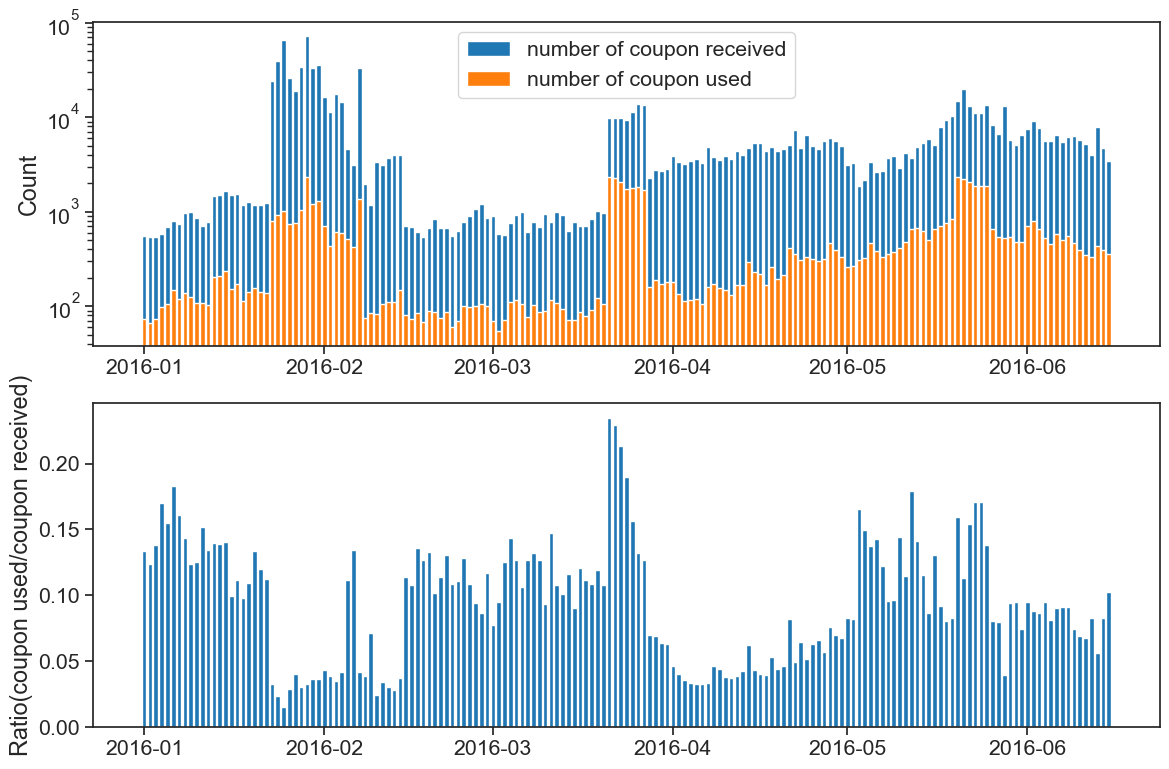

In [143]:
sns.set_style('ticks')
sns.set_context("notebook", font_scale= 1.4)
plt.figure(figsize = (12,8))
date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')

plt.subplot(211)
plt.bar(date_received_dt, couponbydate['count'], label = 'number of coupon received' )
plt.bar(date_received_dt, buybydate['count'], label = 'number of coupon used')
plt.yscale('log')
plt.ylabel('Count')
plt.legend()

plt.subplot(212)
plt.bar(date_received_dt, buybydate['count']/couponbydate['count'])
plt.ylabel('Ratio(coupon used/coupon received)')
plt.tight_layout()

In [144]:
def getWeekday(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

dfoff['weekday'] = dfoff['Date_received'].astype(str).apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].astype(str).apply(getWeekday)

# weekday_type :  周六和周日为1，其他为0
dfoff['weekday_type'] = dfoff['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
dftest['weekday_type'] = dftest['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )

In [145]:
# change weekday to one-hot encoding 
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace('null', np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace('null', np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [146]:
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0
dfoff['label'] = dfoff.apply(label, axis = 1)

In [147]:
print(dfoff['label'].value_counts())

 0    988887
-1    701602
 1     64395
Name: label, dtype: int64


In [148]:
print('已有columns：',dfoff.columns.tolist())

已有columns： ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date', 'discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'label']


In [149]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,...,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,...,null,0,0,0,0,0,0,0,0,-1
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,...,6,1,0,0,0,0,0,1,0,0


In [150]:
# 初步数据集划分  data split  train/valid 的划分：用20160101到20160515的作为train，20160516到20160615作为valid。
df = dfoff[dfoff['label'] != -1].copy()
train = df[(df['Date_received'] < '20160516')].copy()
valid = df[(df['Date_received'] >= '20160516') & (df['Date_received'] <= '20160615')].copy()
print(train['label'].value_counts())
print(valid['label'].value_counts())

0    759172
1     41524
Name: label, dtype: int64
0    229715
1     22871
Name: label, dtype: int64


特征工程

In [151]:
# 再添些特征 feature
original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','distance', 'weekday', 'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)
predictors = original_feature
print(predictors)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']
['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [152]:

def userFeature(df):
    u = df[['User_id']].copy().drop_duplicates()
    
    # u_coupon_count : num of coupon received by user
    u1 = df[df['Date_received'] != 'null'][['User_id']].copy()
    u1['u_coupon_count'] = 1
    u1 = u1.groupby(['User_id'], as_index = False).count()

    # u_buy_count : times of user buy offline (with or without coupon)
    u2 = df[df['Date'] != 'null'][['User_id']].copy()
    u2['u_buy_count'] = 1
    u2 = u2.groupby(['User_id'], as_index = False).count()

    # u_buy_with_coupon : times of user buy offline (with coupon)
    u3 = df[((df['Date'] != 'null') & (df['Date_received'] != 'null'))][['User_id']].copy()
    u3['u_buy_with_coupon'] = 1
    u3 = u3.groupby(['User_id'], as_index = False).count()

    # u_merchant_count : num of merchant user bought from
    u4 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    u4.drop_duplicates(inplace = True)
    u4 = u4.groupby(['User_id'], as_index = False).count()
    u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)

    # u_min_distance
    utmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['User_id', 'distance']].copy()
    utmp.replace(-1, np.nan, inplace = True)
    u5 = utmp.groupby(['User_id'], as_index = False).min()
    u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
    u6 = utmp.groupby(['User_id'], as_index = False).max()
    u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
    u7 = utmp.groupby(['User_id'], as_index = False).mean()
    u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
    u8 = utmp.groupby(['User_id'], as_index = False).median()
    u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)

    user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')

    user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
    user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
    user_feature = user_feature.fillna(0)
    
    print(user_feature.columns.tolist())
    return user_feature


In [153]:

def merchantFeature(df):
    m = df[['Merchant_id']].copy().drop_duplicates()

    # m_coupon_count : num of coupon from merchant
    m1 = df[df['Date_received'] != 'null'][['Merchant_id']].copy()
    m1['m_coupon_count'] = 1
    m1 = m1.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_count : num of sale from merchant (with or without coupon)
    m2 = df[df['Date'] != 'null'][['Merchant_id']].copy()
    m2['m_sale_count'] = 1
    m2 = m2.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_with_coupon : num of sale from merchant with coupon usage
    m3 = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id']].copy()
    m3['m_sale_with_coupon'] = 1
    m3 = m3.groupby(['Merchant_id'], as_index = False).count()

    # m_min_distance
    mtmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
    mtmp.replace(-1, np.nan, inplace = True)
    m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
    m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
    m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
    m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
    m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
    m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
    m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
    m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)

    merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')

    merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
    merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
    merchant_feature = merchant_feature.fillna(0)
    
    print(merchant_feature.columns.tolist())
    return merchant_feature



In [154]:
def usermerchantFeature(df):

    um = df[['User_id', 'Merchant_id']].copy().drop_duplicates()

    um1 = df[['User_id', 'Merchant_id']].copy()
    um1['um_count'] = 1
    um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um2 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    um2['um_buy_count'] = 1
    um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um3 = df[df['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
    um3['um_coupon_count'] = 1
    um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um4 = df[(df['Date_received'] != 'null') & (df['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
    um4['um_buy_with_coupon'] = 1
    um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = user_merchant_feature.fillna(0)

    user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
    user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
    user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
    user_merchant_feature = user_merchant_feature.fillna(0)

    print(user_merchant_feature.columns.tolist())
    return user_merchant_feature


In [155]:
def featureProcess(feature, train, test):
    """
    feature engineering from feature data
    then assign user, merchant, and user_merchant feature for train and test 
    """
    
    user_feature = userFeature(feature)
    merchant_feature = merchantFeature(feature)
    user_merchant_feature = usermerchantFeature(feature)
    
    train = pd.merge(train, user_feature, on = 'User_id', how = 'left')
    train = pd.merge(train, merchant_feature, on = 'Merchant_id', how = 'left')
    train = pd.merge(train, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    train = train.fillna(0)
    
    test = pd.merge(test, user_feature, on = 'User_id', how = 'left')
    test = pd.merge(test, merchant_feature, on = 'Merchant_id', how = 'left')
    test = pd.merge(test, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    test = test.fillna(0)
    
    return train, test

In [156]:
# features
predictors = ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance',
              'weekday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
              'weekday_7', 'weekday_type', 
              'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 
              'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 
              'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance',
              'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 
              'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
print(len(predictors), predictors)

40 ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance', 'weekday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'weekday_type', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [157]:
# repeat result above and process dftest data
feature = dfoff[(dfoff['Date'] < '20160516') | ((dfoff['Date'] == 'null') & (dfoff['Date_received'] < '20160516'))].copy()
data = dfoff[(dfoff['Date_received'] >= '20160516') & (dfoff['Date_received'] <= '20160615')].copy()
print(data['label'].value_counts())
label=data['label']
# feature engineering
train, test = featureProcess(feature, data, dftest)
#train,test=train[predictors],test[predictors]
print(train.shape ,label.shape)
print(train.shape,test.shape)

0    229715
1     22871
Name: label, dtype: int64
['User_id', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
['Merchant_id', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
['User_id', 'Merchant_id', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
(252586, 48) (252586,)
(252586, 48) (113640, 46)


In [158]:

XtrainSub,XvalidSub,ytrainSub,yvalidSub=train_test_split(train,label,test_size=0.2, random_state=100)
 

In [159]:
XtrainSub.head()
print(test.head())

   User_id  Merchant_id  Coupon_id Discount_rate Distance  Date_received  \
0  4129537          450       9983          30:5        1       20160712   
1  6949378         1300       3429          30:5     null       20160706   
2  2166529         7113       6928        200:20        5       20160727   
3  2166529         7113       1808        100:10        5       20160727   
4  6172162         7605       6500          30:1        2       20160708   

   discount_rate  discount_man  discount_jian  discount_type  ...  \
0       0.833333            30              5              1  ...   
1       0.833333            30              5              1  ...   
2       0.900000           200             20              1  ...   
3       0.900000           100             10              1  ...   
4       0.966667            30              1              1  ...   

   m_median_distance  m_coupon_use_rate  m_sale_with_coupon_rate  um_count  \
0                0.0           0.015813           

模型训练

In [160]:
#模型一：逻辑回归做分类
model1= LogisticRegression()
model1=model1.fit(XtrainSub[predictors],ytrainSub)

In [161]:
XvalidSub['pred_prob'] = model1.predict_proba(  XvalidSub[predictors])[:,1]
validgroup = XvalidSub.groupby(['Coupon_id'])
aucs = []

for i in validgroup:
    tmpdf = i[1] 

    if len(tmpdf['label'].astype('int64').unique()) != 2:
        continue
    auc_score=roc_auc_score(tmpdf['label'].astype('int64'), tmpdf['pred_prob'])#, pos_label=1   )
    #from sklearn.utils.multiclass import type_of_target
    #print(type_of_target(tmpdf['pred_prob']))
    #fpr, tpr, thresholds = roc_curve(tmpdf['label'].astype('int64'), tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc_score)
print(np.average(aucs))

0.6010295271414688


In [171]:
# test prediction for submission
y_test_pred = model1.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('result\submit_LogisticRegression.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.035672
1,6949378,3429,20160706,0.247905
2,2166529,6928,20160727,0.001856
3,2166529,1808,20160727,0.012541
4,6172162,6500,20160708,0.065151


In [166]:
#模型二：lightgbm做分类
model2 = lgb.LGBMClassifier(
                    learning_rate = 0.01,
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    metric = 'logloss',
                    max_depth = 5,
                    sub_feature = 0.7,
                    num_leaves = 3,
                    colsample_bytree = 0.7,
                    n_estimators = 5000,
                    early_stop = 50,
                    verbose = -1)
model2.fit(XtrainSub[predictors], ytrainSub)

LGBMClassifier(colsample_bytree=0.7, early_stop=50, learning_rate=0.01,
               max_depth=5, metric='logloss', n_estimators=5000, num_leaves=3,
               objective='binary', sub_feature=0.7, verbose=-1)

In [167]:
XvalidSub['pred_prob'] = model2.predict_proba(  XvalidSub[predictors])[:,1]
validgroup = XvalidSub.groupby(['Coupon_id'])
aucs = []

for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].astype('int64').unique()) != 2:
        continue
    auc_score=roc_auc_score(tmpdf['label'].astype('int64'), tmpdf['pred_prob'])#, pos_label=1   )
    aucs.append(auc_score)
print(np.average(aucs))

0.6325874083873806


In [173]:
# test prediction for submission
y_test_pred = model2.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('result\submit_lightgbm.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.014372
1,6949378,3429,20160706,0.160173
2,2166529,6928,20160727,0.005829
3,2166529,1808,20160727,0.006309
4,6172162,6500,20160708,0.089044


In [179]:
#模型三：xgboost
model3=xgb.XGBClassifier(
                    learning_rate = 0.01,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    max_depth=5,
                    n_estimators = 50,
)
model3.fit(XtrainSub[predictors], ytrainSub)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [180]:
XvalidSub['pred_prob'] = model3.predict_proba(  XvalidSub[predictors])[:,1]
validgroup = XvalidSub.groupby(['Coupon_id'])
aucs = []

for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].astype('int64').unique()) != 2:
        continue
    auc_score=roc_auc_score(tmpdf['label'].astype('int64'), tmpdf['pred_prob'])#, pos_label=1   )
    aucs.append(auc_score)
print(np.average(aucs))

0.6192670076697


In [181]:
# test prediction for submission
y_test_pred = model3.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('result\submit_xgboost.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.312979
1,6949378,3429,20160706,0.337725
2,2166529,6928,20160727,0.311204
3,2166529,1808,20160727,0.311204
4,6172162,6500,20160708,0.348056


In [182]:
#模型四：catboost
model4=CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        learning_rate=0.01,
        iterations=10000,
        random_seed=42,
        od_type="Iter",
        depth=10,
        early_stopping_rounds=500           
)
model4.fit(XtrainSub[predictors], ytrainSub)

0:	total: 220ms	remaining: 36m 36s
1:	total: 265ms	remaining: 22m 2s
2:	total: 310ms	remaining: 17m 14s
3:	total: 355ms	remaining: 14m 48s
4:	total: 404ms	remaining: 13m 27s
5:	total: 450ms	remaining: 12m 29s
6:	total: 498ms	remaining: 11m 51s
7:	total: 542ms	remaining: 11m 16s
8:	total: 586ms	remaining: 10m 50s
9:	total: 629ms	remaining: 10m 28s
10:	total: 673ms	remaining: 10m 11s
11:	total: 719ms	remaining: 9m 58s
12:	total: 762ms	remaining: 9m 45s
13:	total: 808ms	remaining: 9m 35s
14:	total: 855ms	remaining: 9m 28s
15:	total: 906ms	remaining: 9m 25s
16:	total: 957ms	remaining: 9m 22s
17:	total: 1s	remaining: 9m 17s
18:	total: 1.05s	remaining: 9m 12s
19:	total: 1.1s	remaining: 9m 8s
20:	total: 1.15s	remaining: 9m 5s
21:	total: 1.19s	remaining: 9m 1s
22:	total: 1.24s	remaining: 8m 56s
23:	total: 1.28s	remaining: 8m 52s
24:	total: 1.32s	remaining: 8m 47s
25:	total: 1.37s	remaining: 8m 44s
26:	total: 1.41s	remaining: 8m 42s
27:	total: 1.46s	remaining: 8m 38s
28:	total: 1.5s	remaining: 

In [183]:
XvalidSub['pred_prob'] = model4.predict_proba(  XvalidSub[predictors])[:,1]
validgroup = XvalidSub.groupby(['Coupon_id'])
aucs = []

for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].astype('int64').unique()) != 2:
        continue
    auc_score=roc_auc_score(tmpdf['label'].astype('int64'), tmpdf['pred_prob'])#, pos_label=1   )
    aucs.append(auc_score)
print(np.average(aucs))

0.6520105719986213


In [184]:
# test prediction for submission
y_test_pred = model4.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('result\submit_catboost.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.014486
1,6949378,3429,20160706,0.140313
2,2166529,6928,20160727,0.003317
3,2166529,1808,20160727,0.005734
4,6172162,6500,20160708,0.005501


模型调参优化

In [187]:
import sklearn 
print(sklearn.metrics.get_scorer_names())
#使用lightgbm
from sklearn.model_selection import cross_val_score,KFold
from bayes_opt import BayesianOptimization
# pip install bayesian-optimization
x,y=XtrainSub[predictors], ytrainSub
# 设置几个参数
def lgb_cv(colsample_bytree, min_child_samples, num_leaves, subsample, max_depth):
    model = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',
           colsample_bytree=float(colsample_bytree), learning_rate=0.01,
           min_child_samples=int(min_child_samples), min_child_weight=0.001, 
           n_estimators=800, n_jobs=-1, num_leaves=int(num_leaves),
           random_state=None, reg_alpha=0.0, reg_lambda=0.0,max_depth=int(max_depth),
           subsample=float(subsample))
    cv_score = cross_val_score(model, x, y, scoring="roc_auc", cv=5).mean()
    return cv_score
# 使用贝叶斯优化
lgb_bo = BayesianOptimization(
        lgb_cv,
        {'colsample_bytree': (0.7,1),
        'min_child_samples': (2, 25),
        'num_leaves': (5, 250),
        'subsample': (0.7, 1),
        'max_depth':(2,10)}
    )
lgb_bo.maximize()
lgb_bo.max
# 将优化好的参数带入进行使用
model = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',
           colsample_bytree=0.7111, learning_rate=0.01,
           min_child_samples=9, min_child_weight=0.001, 
           n_estimators=800, n_jobs=-1, num_leaves=188,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0,max_depth=2,
           subsample=0.91)
cv_score = cross_val_score(model, x, y, scoring="roc_auc", cv=5).mean()
cv_score

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

0.8233391719273074

In [190]:
model.fit(x,y)
XvalidSub['pred_prob'] = model.predict_proba(  XvalidSub[predictors])[:,1]
validgroup = XvalidSub.groupby(['Coupon_id'])
aucs = []

for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].astype('int64').unique()) != 2:
        continue
    auc_score=roc_auc_score(tmpdf['label'].astype('int64'), tmpdf['pred_prob'])#, pos_label=1   )
    aucs.append(auc_score)
print(np.average(aucs))


[LightGBM] [Info] Number of positive: 18365, number of negative: 183703
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 202068, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090885 -> initscore=-2.302874
[LightGBM] [Info] Start training from score -2.302874
0.6273275635876798


In [191]:
# test prediction for submission
y_test_pred = model.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('result\submit_lightgbm调参优化.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.020474
1,6949378,3429,20160706,0.119901
2,2166529,6928,20160727,0.013839
3,2166529,1808,20160727,0.013839
4,6172162,6500,20160708,0.117549


模型融合

In [192]:
#融合一个catboost和lightgbm的结果
model4_1=CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        learning_rate=0.01,
        iterations=10000,
        random_seed=42,
        od_type="Iter",
        depth=10,
        early_stopping_rounds=500           
)
model4_1.fit(train[predictors], label)
model2_1 = lgb.LGBMClassifier(
                    learning_rate = 0.01,
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    metric = 'logloss',
                    max_depth = 5,
                    sub_feature = 0.7,
                    num_leaves = 3,
                    colsample_bytree = 0.7,
                    n_estimators = 5000,
                    early_stop = 50,
                    verbose = -1)
model2_1.fit(train[predictors], label)

0:	total: 59.4ms	remaining: 9m 54s
1:	total: 118ms	remaining: 9m 49s
2:	total: 177ms	remaining: 9m 48s
3:	total: 243ms	remaining: 10m 7s
4:	total: 309ms	remaining: 10m 17s
5:	total: 373ms	remaining: 10m 21s
6:	total: 434ms	remaining: 10m 20s
7:	total: 492ms	remaining: 10m 14s
8:	total: 554ms	remaining: 10m 15s
9:	total: 616ms	remaining: 10m 14s
10:	total: 675ms	remaining: 10m 13s
11:	total: 734ms	remaining: 10m 10s
12:	total: 795ms	remaining: 10m 10s
13:	total: 854ms	remaining: 10m 9s
14:	total: 913ms	remaining: 10m 7s
15:	total: 976ms	remaining: 10m 8s
16:	total: 1.05s	remaining: 10m 15s
17:	total: 1.12s	remaining: 10m 20s
18:	total: 1.18s	remaining: 10m 19s
19:	total: 1.24s	remaining: 10m 18s
20:	total: 1.3s	remaining: 10m 19s
21:	total: 1.36s	remaining: 10m 18s
22:	total: 1.42s	remaining: 10m 18s
23:	total: 1.48s	remaining: 10m 16s
24:	total: 1.54s	remaining: 10m 15s
25:	total: 1.6s	remaining: 10m 15s
26:	total: 1.66s	remaining: 10m 14s
27:	total: 1.73s	remaining: 10m 17s
28:	total:

LGBMClassifier(colsample_bytree=0.7, early_stop=50, learning_rate=0.01,
               max_depth=5, metric='logloss', n_estimators=5000, num_leaves=3,
               objective='binary', sub_feature=0.7, verbose=-1)

In [193]:
# test prediction for submission
y_test_pred2_1 = model2_1.predict_proba(test[predictors])
y_test_pred4_1 = model4_1.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = (y_test_pred2_1[:,1]+y_test_pred4_1[:,1])/2
submit.to_csv('result\submit_catboost_lightgbm.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.013662
1,6949378,3429,20160706,0.152583
2,2166529,6928,20160727,0.006665
3,2166529,1808,20160727,0.008107
4,6172162,6500,20160708,0.045958


In [194]:
train.corr()

,User_id,Merchant_id,discount_rate,discount_man,discount_jian,discount_type,distance,weekday,weekday_type,weekday_1,...,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
User_id,1.000000,0.003042,-0.001708,0.001253,0.001782,0.002029,0.000070,0.000234,-0.001855,0.000771,...,-0.002199,0.004040,0.001369,-0.000935,-0.000288,0.007927,0.011944,-0.003835,-0.001382,-0.000715
Merchant_id,0.003042,1.000000,0.224286,0.052697,-0.056816,-0.074235,-0.021266,0.022212,0.020516,0.007703,...,0.034999,0.154025,0.058619,0.077812,0.075689,0.072812,0.061776,0.065117,0.064516,0.065626
discount_rate,-0.001708,0.224286,1.000000,0.090162,-0.395322,-0.089091,-0.005756,-0.021867,-0.048046,-0.009199,...,-0.081744,0.033566,0.013528,0.068310,0.067617,0.045681,0.034395,-0.045581,0.052435,0.045818
discount_man,0.001253,0.052697,0.090162,1.000000,0.775280,0.138371,0.117188,0.106106,0.158215,-0.022435,...,0.170629,-0.187082,-0.021517,-0.091416,-0.088287,-0.054855,-0.032372,-0.126231,-0.059470,-0.045630
discount_jian,0.001782,-0.056816,-0.395322,0.775280,1.000000,0.126319,0.103173,0.103991,0.170446,0.014266,...,0.260340,-0.153963,0.013538,-0.107614,-0.104859,-0.062261,-0.037636,-0.079401,-0.071202,-0.054636
discount_type,0.002029,-0.074235,-0.089091,0.138371,0.126319,1.000000,-0.030622,-0.001790,-0.001977,-0.001557,...,-0.090449,-0.072214,-0.143664,-0.022117,-0.024585,-0.035828,-0.044618,-0.005213,-0.032799,-0.039797
distance,0.000070,-0.021266,-0.005756,0.117188,0.103173,-0.030622,1.000000,0.037092,0.046222,-0.014108,...,0.090622,-0.095614,-0.039955,-0.085658,-0.083170,-0.051401,-0.031497,-0.058477,-0.064649,-0.059556
weekday,0.000234,0.022212,-0.021867,0.106106,0.103991,-0.001790,0.037092,1.000000,0.787505,-0.612175,...,-0.057869,-0.010135,-0.014452,-0.039806,-0.033256,-0.033248,-0.012247,-0.013539,-0.020939,-0.019951
weekday_type,-0.001855,0.020516,-0.048046,0.158215,0.170446,-0.001977,0.046222,0.787505,1.000000,-0.257057,...,-0.002699,-0.024340,-0.045495,-0.039652,-0.030986,-0.038743,-0.013645,-0.004782,-0.023142,-0.023473
weekday_1,0.000771,0.007703,-0.009199,-0.022435,0.014266,-0.001557,-0.014108,-0.612175,-0.257057,1.000000,...,0.115222,-0.001108,-0.012533,0.010181,0.011281,0.004674,0.005602,-0.010902,0.009911,0.005877


In [195]:
data.corr()

,User_id,Merchant_id,discount_rate,discount_man,discount_jian,distance,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label
User_id,1.000000,0.003042,-0.001708,0.001253,0.001782,0.000070,-0.001855,0.000771,-0.002140,0.000094,0.000244,0.003471,-0.002983,0.000919,0.007113
Merchant_id,0.003042,1.000000,0.224286,0.052697,-0.056816,-0.021266,0.020516,0.007703,-0.011805,-0.037490,0.002811,0.014139,0.008086,0.019613,0.078834
discount_rate,-0.001708,0.224286,1.000000,0.090162,-0.395322,-0.005756,-0.048046,-0.009199,0.052381,-0.034118,0.039684,0.016419,-0.081913,0.029359,0.056635
discount_man,0.001253,0.052697,0.090162,1.000000,0.775280,0.117188,0.158215,-0.022435,-0.040706,-0.087452,-0.013847,-0.037602,0.204492,-0.018676,-0.103569
discount_jian,0.001782,-0.056816,-0.395322,0.775280,1.000000,0.103173,0.170446,0.014266,-0.077306,-0.082808,-0.037163,-0.035635,0.222644,-0.022922,-0.097955
distance,0.000070,-0.021266,-0.005756,0.117188,0.103173,1.000000,0.046222,-0.014108,-0.015413,-0.011117,-0.010720,-0.008507,0.043831,0.013565,-0.080979
weekday_type,-0.001855,0.020516,-0.048046,0.158215,0.170446,0.046222,1.000000,-0.257057,-0.256821,-0.275810,-0.250319,-0.254248,0.722671,0.563185,-0.011870
weekday_1,0.000771,0.007703,-0.009199,-0.022435,0.014266,-0.014108,-0.257057,1.000000,-0.163680,-0.175782,-0.159536,-0.162040,-0.185767,-0.144770,0.015768
weekday_2,-0.002140,-0.011805,0.052381,-0.040706,-0.077306,-0.015413,-0.256821,-0.163680,1.000000,-0.175621,-0.159390,-0.161891,-0.185597,-0.144638,0.013678
weekday_3,0.000094,-0.037490,-0.034118,-0.087452,-0.082808,-0.011117,-0.275810,-0.175782,-0.175621,1.000000,-0.171175,-0.173862,-0.199320,-0.155332,0.002827


调整特征

In [196]:
import datetime
import os
from concurrent.futures import ProcessPoolExecutor
from math import ceil
import pandas as pd


# 读入源数据
def get_source_data():
    # 源数据路径
    DataPath = 'data'

    # 读入源数据
    off_train = pd.read_csv(os.path.join(DataPath, 'ccf_offline_stage1_train.csv'),
                            parse_dates=['Date_received', 'Date'])
    off_train.columns = ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date']

    on_train = pd.read_csv(os.path.join(DataPath, 'ccf_online_stage1_train.csv'), parse_dates=['Date_received', 'Date'])
    on_train.columns = ['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate', 'Date_received', 'Date']

    off_test = pd.read_csv(os.path.join(DataPath, 'ccf_offline_stage1_test_revised.csv'), parse_dates=['Date_received'])
    off_test.columns = ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received']

    print(off_train.info())
    print(off_train.head(5))
    return off_train, on_train, off_test


# In[] null,na 特殊处理
def null_process_offline(dataset, predict=False):
    dataset.Distance.fillna(11, inplace=True)
    dataset.Distance = dataset.Distance.astype(int)
    dataset.Coupon_id.fillna(0, inplace=True)
    dataset.Coupon_id = dataset.Coupon_id.astype(int)
    dataset.Date_received.fillna(date_null, inplace=True)

    dataset[['discount_rate_x', 'discount_rate_y']] = dataset[dataset.Discount_rate.str.contains(':') == True][
        'Discount_rate'].str.split(':', expand=True).astype(int)
    dataset['discount_rate'] = 1 - dataset.discount_rate_y / dataset.discount_rate_x
    dataset.discount_rate = dataset.discount_rate.fillna(dataset.Discount_rate).astype(float)
    if predict:
        return dataset
    else:
        dataset.Date.fillna(date_null, inplace=True)
        return dataset


def null_process_online(dataset):
    dataset.Coupon_id.fillna(0, inplace=True)
    # online.Coupon_id = online.Coupon_id.astype(int)
    dataset.Date_received.fillna(date_null, inplace=True)
    dataset.Date.fillna(date_null, inplace=True)
    return dataset


# In[] 生成交叉训练集
def data_process(off_train, on_train, off_test):
    # train feature split
    # 交叉训练集一：收到券的日期大于4月14日和小于5月14日
    time_range = ['2016-04-16', '2016-05-15']
    dataset1 = off_train[(off_train.Date_received >= time_range[0]) & (off_train.Date_received <= time_range[1])].copy()
    dataset1['label'] = 0
    dataset1.loc[
        (dataset1.Date != date_null) & (dataset1.Date - dataset1.Date_received <= datetime.timedelta(15)), 'label'] = 1
    # 交叉训练集一特征offline：线下数据中领券和用券日期大于1月1日和小于4月13日
    time_range_date_received = ['2016-01-01', '2016-03-31']
    time_range_date = ['2016-01-01', '2016-04-15']
    feature1_off = off_train[(off_train.Date >= time_range_date[0]) & (off_train.Date <= time_range_date[1]) | (
            (off_train.Coupon_id == 0) & (off_train.Date_received >= time_range_date_received[0]) & (
            off_train.Date_received <= time_range_date_received[1]))]
    # 交叉训练集一特征online：线上数据中领券和用券日期大于1月1日和小于4月13日[on_train.date == 'null' to on_train.coupon_id == 0]
    feature1_on = on_train[(on_train.Date >= time_range_date[0]) & (on_train.Date <= time_range_date[1]) | (
            (on_train.Coupon_id == 0) & (on_train.Date_received >= time_range_date_received[0]) & (
            on_train.Date_received <= time_range_date_received[1]))]

    # 交叉训练集二：收到券的日期大于5月15日和小于6月15日
    time_range = ['2016-05-16', '2016-06-15']
    dataset2 = off_train[(off_train.Date_received >= time_range[0]) & (off_train.Date_received <= time_range[1])]
    dataset2['label'] = 0
    dataset2.loc[
        (dataset2.Date != date_null) & (dataset2.Date - dataset2.Date_received <= datetime.timedelta(15)), 'label'] = 1
    # 交叉训练集二特征offline：线下数据中领券和用券日期大于2月1日和小于5月14日
    time_range_date_received = ['2016-02-01', '2016-04-30']
    time_range_date = ['2016-02-01', '2016-05-15']
    feature2_off = off_train[(off_train.Date >= time_range_date[0]) & (off_train.Date <= time_range_date[1]) | (
            (off_train.Coupon_id == 0) & (off_train.Date_received >= time_range_date_received[0]) & (
            off_train.Date_received <= time_range_date_received[1]))]
    # 交叉训练集二特征online：线上数据中领券和用券日期大于2月1日和小于5月14日
    feature2_on = on_train[(on_train.Date >= time_range_date[0]) & (on_train.Date <= time_range_date[1]) | (
            (on_train.Coupon_id == 0) & (on_train.Date_received >= time_range_date_received[0]) & (
            on_train.Date_received <= time_range_date_received[1]))]

    # 测试集
    dataset3 = off_test
    # 测试集特征offline :线下数据中领券和用券日期大于3月15日和小于6月30日的
    time_range = ['2016-03-16', '2016-06-30']
    feature3_off = off_train[((off_train.Date >= time_range[0]) & (off_train.Date <= time_range[1])) | (
            (off_train.Coupon_id == 0) & (off_train.Date_received >= time_range[0]) & (
            off_train.Date_received <= time_range[1]))]
    # 测试集特征online :线上数据中领券和用券日期大于3月15日和小于6月30日的
    feature3_on = on_train[((on_train.Date >= time_range[0]) & (on_train.Date <= time_range[1])) | (
            (on_train.Coupon_id == 0) & (on_train.Date_received >= time_range[0]) & (
            on_train.Date_received <= time_range[1]))]

    # get train feature
    ProcessDataSet1 = get_features(dataset1, feature1_off, feature1_on)
    ProcessDataSet2 = get_features(dataset2, feature2_off, feature2_on)
    ProcessDataSet3 = get_features(dataset3, feature3_off, feature3_on)

    return ProcessDataSet1, ProcessDataSet2, ProcessDataSet3


def get_features(dataset, feature_off, feature_on):
    dataset = get_offline_features(dataset, feature_off)
    return get_online_features(feature_on, dataset)


# In[] 定义获取feature的函数
def get_offline_features(X, offline):
    # X = X[:1000]

    print(len(X), len(X.columns))

    temp = offline[offline.Coupon_id != 0]
    coupon_consume = temp[temp.Date != date_null]
    coupon_no_consume = temp[temp.Date == date_null]

    user_coupon_consume = coupon_consume.groupby('User_id')

    X['weekday'] = X.Date_received.dt.weekday
    X['day'] = X.Date_received.dt.day

    # # 距离优惠券消费次数
    # temp = coupon_consume.groupby('Distance').size().reset_index(name='distance_0')
    # X = pd.merge(X, temp, how='left', on='Distance')
    #
    # # 距离优惠券不消费次数
    # temp = coupon_no_consume.groupby('Distance').size().reset_index(name='distance_1')
    # X = pd.merge(X, temp, how='left', on='Distance')
    #
    # # 距离优惠券领取次数
    # X['distance_2'] = X.distance_0 + X.distance_1
    #
    # # 距离优惠券消费率
    # X['distance_3'] = X.distance_0 / X.distance_2

    # temp = coupon_consume[coupon_consume.Distance != 11].groupby('Distance').size()
    # temp['d4'] = temp.Distance.sum() / len(temp)
    # X = pd.merge(X, temp, how='left', on='Distance')

    '''user features'''

    # 优惠券消费次数
    temp = user_coupon_consume.size().reset_index(name='u2')
    X = pd.merge(X, temp, how='left', on='User_id')
    # X.u2.fillna(0, inplace=True)
    # X.u2 = X.u2.astype(int)

    # 优惠券不消费次数
    temp = coupon_no_consume.groupby('User_id').size().reset_index(name='u3')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 使用优惠券次数与没使用优惠券次数比值
    X['u19'] = X.u2 / X.u3

    # 领取优惠券次数
    X['u1'] = X.u2.fillna(0) + X.u3.fillna(0)

    # 优惠券核销率
    X['u4'] = X.u2 / X.u1

    # 普通消费次数
    temp = offline[(offline.Coupon_id == 0) & (offline.Date != date_null)]
    temp1 = temp.groupby('User_id').size().reset_index(name='u5')
    X = pd.merge(X, temp1, how='left', on='User_id')

    # 一共消费多少次
    X['u25'] = X.u2 + X.u5

    # 用户使用优惠券消费占比
    X['u20'] = X.u2 / X.u25

    # 正常消费平均间隔
    temp = pd.merge(temp, temp.groupby('User_id').Date.max().reset_index(name='max'))
    temp = pd.merge(temp, temp.groupby('User_id').Date.min().reset_index(name='min'))
    temp = pd.merge(temp, temp.groupby('User_id').size().reset_index(name='len'))
    temp['u6'] = ((temp['max'] - temp['min']).dt.days / (temp['len'] - 1))
    temp = temp.drop_duplicates('User_id')
    X = pd.merge(X, temp[['User_id', 'u6']], how='left', on='User_id')

    # 优惠券消费平均间隔
    temp = pd.merge(coupon_consume, user_coupon_consume.Date.max().reset_index(name='max'))
    temp = pd.merge(temp, temp.groupby('User_id').Date.min().reset_index(name='min'))
    temp = pd.merge(temp, temp.groupby('User_id').size().reset_index(name='len'))
    temp['u7'] = ((temp['max'] - temp['min']).dt.days / (temp['len'] - 1))
    temp = temp.drop_duplicates('User_id')
    X = pd.merge(X, temp[['User_id', 'u7']], how='left', on='User_id')

    # 15天内平均会普通消费几次
    X['u8'] = X.u6 / 15

    # 15天内平均会优惠券消费几次
    X['u9'] = X.u7 / 15

    # 领取优惠券到使用优惠券的平均间隔时间
    temp = coupon_consume.copy()
    temp['days'] = (temp.Date - temp.Date_received).dt.days
    temp = (temp.groupby('User_id').days.sum() / temp.groupby('User_id').size()).reset_index(name='u10')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 在15天内使用掉优惠券的值大小
    X['u11'] = X.u10 / 15

    # 领取优惠券到使用优惠券间隔小于15天的次数
    temp = coupon_consume.copy()
    temp['days'] = (temp.Date - temp.Date_received).dt.days
    temp = temp[temp.days <= 15]
    temp = temp.groupby('User_id').size().reset_index(name='u21')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户15天使用掉优惠券的次数除以使用优惠券的次数
    X['u22'] = X.u21 / X.u2

    # 用户15天使用掉优惠券的次数除以领取优惠券未消费的次数
    X['u23'] = X.u21 / X.u3

    # 用户15天使用掉优惠券的次数除以领取优惠券的总次数
    X['u24'] = X.u21 / X.u1

    # 消费优惠券的平均折率
    temp = user_coupon_consume.discount_rate.mean().reset_index(name='u45')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销优惠券的最低消费折率
    temp = user_coupon_consume.discount_rate.min().reset_index(name='u27')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销优惠券的最高消费折率
    temp = user_coupon_consume.discount_rate.max().reset_index(name='u28')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销过的不同优惠券数量
    temp = coupon_consume.groupby(['User_id', 'Coupon_id']).size()
    temp = temp.groupby('User_id').size().reset_index(name='u32')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户领取所有不同优惠券数量
    temp = offline[offline.Date_received != date_null]
    temp = temp.groupby(['User_id', 'Coupon_id']).size().reset_index(name='u47')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Coupon_id'])

    # 用户核销过的不同优惠券数量占所有不同优惠券的比重
    X['u33'] = X.u32 / X.u47

    # 用户平均每种优惠券核销多少张
    X['u34'] = X.u2 / X.u47

    # 核销优惠券用户-商家平均距离
    temp = offline[(offline.Coupon_id != 0) & (offline.Date != date_null) & (offline.Distance != 11)]
    temp = temp.groupby('User_id').Distance
    temp = pd.merge(temp.count().reset_index(name='x'), temp.sum().reset_index(name='y'), on='User_id')
    temp['u35'] = temp.y / temp.x
    temp = temp[['User_id', 'u35']]
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销优惠券中的最小用户-商家距离
    temp = coupon_consume[coupon_consume.Distance != 11]
    temp = temp.groupby('User_id').Distance.min().reset_index(name='u36')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销优惠券中的最大用户-商家距离
    temp = coupon_consume[coupon_consume.Distance != 11]
    temp = temp.groupby('User_id').Distance.max().reset_index(name='u37')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 优惠券类型
    discount_types = [
        '0.2', '0.5', '0.6', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95', '30:20', '50:30', '10:5',
        '20:10', '100:50', '200:100', '50:20', '30:10', '150:50', '100:30', '20:5', '200:50', '5:1',
        '50:10', '100:20', '150:30', '30:5', '300:50', '200:30', '150:20', '10:1', '50:5', '100:10',
        '200:20', '300:30', '150:10', '300:20', '500:30', '20:1', '100:5', '200:10', '30:1', '150:5',
        '300:10', '200:5', '50:1', '100:1',
    ]
    X['discount_type'] = -1
    for k, v in enumerate(discount_types):
        X.loc[X.Discount_rate == v, 'discount_type'] = k

    # 不同优惠券领取次数
    temp = offline.groupby(['User_id', 'Discount_rate']).size().reset_index(name='u41')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Discount_rate'])

    # 不同优惠券使用次数
    temp = coupon_consume.groupby(['User_id', 'Discount_rate']).size().reset_index(name='u42')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Discount_rate'])

    # 不同优惠券不使用次数
    temp = coupon_no_consume.groupby(['User_id', 'Discount_rate']).size().reset_index(name='u43')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Discount_rate'])

    # 不同打折优惠券使用率
    X['u44'] = X.u42 / X.u41

    # 满减类型优惠券领取次数
    temp = offline[offline.Discount_rate.str.contains(':') == True]
    temp = temp.groupby('User_id').size().reset_index(name='u48')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 打折类型优惠券领取次数
    temp = offline[offline.Discount_rate.str.contains('\.') == True]
    temp = temp.groupby('User_id').size().reset_index(name='u49')
    X = pd.merge(X, temp, how='left', on='User_id')

    '''offline merchant features'''

    # 商户消费次数
    temp = offline[offline.Date != date_null].groupby('Merchant_id').size().reset_index(name='m0')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家优惠券被领取后核销次数
    temp = coupon_consume.groupby('Merchant_id').size().reset_index(name='m1')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商户正常消费笔数
    X['m2'] = X.m0.fillna(0) - X.m1.fillna(0)

    # 商家优惠券被领取次数
    temp = offline[offline.Date_received != date_null].groupby('Merchant_id').size().reset_index(name='m3')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家优惠券被领取后核销率
    X['m4'] = X.m1 / X.m3

    # 商家优惠券被领取后不核销次数
    temp = coupon_no_consume.groupby('Merchant_id').size().reset_index(name='m7')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商户当天优惠券领取次数
    temp = X[X.Date_received != date_null]
    temp = temp.groupby(['Merchant_id', 'Date_received']).size().reset_index(name='m5')
    X = pd.merge(X, temp, how='left', on=['Merchant_id', 'Date_received'])

    # 商户当天优惠券领取人数
    temp = X[X.Date_received != date_null]
    temp = temp.groupby(['User_id', 'Merchant_id', 'Date_received']).size().reset_index()
    temp = temp.groupby(['Merchant_id', 'Date_received']).size().reset_index(name='m6')
    X = pd.merge(X, temp, how='left', on=['Merchant_id', 'Date_received'])

    # 商家优惠券核销的平均消费折率
    temp = coupon_consume.groupby('Merchant_id').discount_rate.mean().reset_index(name='m8')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家优惠券核销的最小消费折率
    temp = coupon_consume.groupby('Merchant_id').discount_rate.max().reset_index(name='m9')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家优惠券核销的最大消费折率
    temp = coupon_consume.groupby('Merchant_id').discount_rate.min().reset_index(name='m10')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家优惠券核销不同的用户数量
    temp = coupon_consume.groupby(['Merchant_id', 'User_id']).size()
    temp = temp.groupby('Merchant_id').size().reset_index(name='m11')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家优惠券领取不同的用户数量
    temp = offline[offline.Date_received != date_null].groupby(['Merchant_id', 'User_id']).size()
    temp = temp.groupby('Merchant_id').size().reset_index(name='m12')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 核销商家优惠券的不同用户数量其占领取不同的用户比重
    X['m13'] = X.m11 / X.m12

    # 商家优惠券平均每个用户核销多少张
    X['m14'] = X.m1 / X.m12

    # 商家被核销过的不同优惠券数量
    temp = coupon_consume.groupby(['Merchant_id', 'Coupon_id']).size()
    temp = temp.groupby('Merchant_id').size().reset_index(name='m15')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家领取过的不同优惠券数量的比重
    temp = offline[offline.Date_received != date_null].groupby(['Merchant_id', 'Coupon_id']).size()
    temp = temp.groupby('Merchant_id').count().reset_index(name='m18')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家被核销过的不同优惠券数量占所有领取过的不同优惠券数量的比重
    X['m19'] = X.m15 / X.m18

    # 商家被核销优惠券的平均时间
    temp = pd.merge(coupon_consume, coupon_consume.groupby('Merchant_id').Date.max().reset_index(name='max'))
    temp = pd.merge(temp, temp.groupby('Merchant_id').Date.min().reset_index(name='min'))
    temp = pd.merge(temp, temp.groupby('Merchant_id').size().reset_index(name='len'))
    temp['m20'] = ((temp['max'] - temp['min']).dt.days / (temp['len'] - 1))
    temp = temp.drop_duplicates('Merchant_id')
    X = pd.merge(X, temp[['Merchant_id', 'm20']], how='left', on='Merchant_id')

    # 商家被核销优惠券中的用户-商家平均距离
    temp = coupon_consume[coupon_consume.Distance != 11].groupby('Merchant_id').Distance
    temp = pd.merge(temp.count().reset_index(name='x'), temp.sum().reset_index(name='y'), on='Merchant_id')
    temp['m21'] = temp.y / temp.x
    temp = temp[['Merchant_id', 'm21']]
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家被核销优惠券中的用户-商家最小距离
    temp = coupon_consume[coupon_consume.Distance != 11]
    temp = temp.groupby('Merchant_id').Distance.min().reset_index(name='m22')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家被核销优惠券中的用户-商家最大距离
    temp = coupon_consume[coupon_consume.Distance != 11]
    temp = temp.groupby('Merchant_id').Distance.max().reset_index(name='m23')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    """offline coupon features"""

    # 此优惠券一共发行多少张
    temp = offline[offline.Coupon_id != 0].groupby('Coupon_id').size().reset_index(name='c1')
    X = pd.merge(X, temp, how='left', on='Coupon_id')

    # 此优惠券一共被使用多少张
    temp = coupon_consume.groupby('Coupon_id').size().reset_index(name='c2')
    X = pd.merge(X, temp, how='left', on='Coupon_id')

    # 优惠券使用率
    X['c3'] = X.c2 / X.c1

    # 没有使用的数目
    X['c4'] = X.c1 - X.c2

    # 此优惠券在当天发行了多少张
    temp = X.groupby(['Coupon_id', 'Date_received']).size().reset_index(name='c5')
    X = pd.merge(X, temp, how='left', on=['Coupon_id', 'Date_received'])

    # 优惠券类型(直接优惠为0, 满减为1)
    X['c6'] = 0
    X.loc[X.Discount_rate.str.contains(':') == True, 'c6'] = 1

    # 不同打折优惠券领取次数
    temp = offline.groupby('Discount_rate').size().reset_index(name='c8')
    X = pd.merge(X, temp, how='left', on='Discount_rate')

    # 不同打折优惠券使用次数
    temp = coupon_consume.groupby('Discount_rate').size().reset_index(name='c9')
    X = pd.merge(X, temp, how='left', on='Discount_rate')

    # 不同打折优惠券不使用次数
    temp = coupon_no_consume.groupby('Discount_rate').size().reset_index(name='c10')
    X = pd.merge(X, temp, how='left', on='Discount_rate')

    # 不同打折优惠券使用率
    X['c11'] = X.c9 / X.c8

    # 优惠券核销平均时间
    temp = pd.merge(coupon_consume, coupon_consume.groupby('Coupon_id').Date.max().reset_index(name='max'))
    temp = pd.merge(temp, temp.groupby('Coupon_id').Date.min().reset_index(name='min'))
    temp = pd.merge(temp, temp.groupby('Coupon_id').size().reset_index(name='count'))
    temp['c12'] = ((temp['max'] - temp['min']).dt.days / (temp['count'] - 1))
    temp = temp.drop_duplicates('Coupon_id')
    X = pd.merge(X, temp[['Coupon_id', 'c12']], how='left', on='Coupon_id')

    '''user merchant feature'''

    # 用户领取商家的优惠券次数
    temp = offline[offline.Coupon_id != 0]
    temp = temp.groupby(['User_id', 'Merchant_id']).size().reset_index(name='um1')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id'])

    # 用户领取商家的优惠券后不核销次数
    temp = coupon_no_consume.groupby(['User_id', 'Merchant_id']).size().reset_index(name='um2')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id'])

    # 用户领取商家的优惠券后核销次数
    temp = coupon_consume.groupby(['User_id', 'Merchant_id']).size().reset_index(name='um3')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id'])

    # 用户领取商家的优惠券后核销率
    X['um4'] = X.um3 / X.um1

    # 用户对每个商家的不核销次数占用户总的不核销次数的比重
    temp = coupon_no_consume.groupby('User_id').size().reset_index(name='temp')
    X = pd.merge(X, temp, how='left', on='User_id')
    X['um5'] = X.um2 / X.temp
    X.drop(columns='temp', inplace=True)

    # 用户在商店总共消费过几次
    temp = offline[offline.Date != date_null].groupby(['User_id', 'Merchant_id']).size().reset_index(name='um6')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id'])

    # 用户在商店普通消费次数
    temp = offline[(offline.Coupon_id == 0) & (offline.Date != date_null)]
    temp = temp.groupby(['User_id', 'Merchant_id']).size().reset_index(name='um7')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id'])

    # 用户当天在此商店领取的优惠券数目
    temp = offline[offline.Date_received != date_null]
    temp = temp.groupby(['User_id', 'Merchant_id', 'Date_received']).size().reset_index(name='um8')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id', 'Date_received'])

    # 用户领取优惠券不同商家数量
    temp = offline[offline.Coupon_id == offline.Coupon_id]
    temp = temp.groupby(['User_id', 'Merchant_id']).size().reset_index()
    temp = temp.groupby('User_id').size().reset_index(name='um9')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销优惠券不同商家数量
    temp = coupon_consume.groupby(['User_id', 'Merchant_id']).size()
    temp = temp.groupby('User_id').size().reset_index(name='um10')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户核销过优惠券的不同商家数量占所有不同商家的比重
    X['um11'] = X.um10 / X.um9

    # 用户平均核销每个商家多少张优惠券
    X['um12'] = X.u2 / X.um9

    '''other feature'''

    # 用户领取的所有优惠券数目
    temp = X.groupby('User_id').size().reset_index(name='o1')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户领取的特定优惠券数目
    temp = X.groupby(['User_id', 'Coupon_id']).size().reset_index(name='o2')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Coupon_id'])

    # multiple threads
    # data split
    stop = len(X)
    step = int(ceil(stop / cpu_jobs))

    X_chunks = [X[i:i + step] for i in range(0, stop, step)]
    X_list = [X] * cpu_jobs
    counters = [i for i in range(cpu_jobs)]

    start = datetime.datetime.now()
    with ProcessPoolExecutor() as e:
        X = pd.concat(e.map(task, X_chunks, X_list, counters))
        print('time:', str(datetime.datetime.now() - start).split('.')[0])
    # multiple threads

    # 用户领取优惠券平均时间间隔
    temp = pd.merge(X, X.groupby('User_id').Date_received.max().reset_index(name='max'))
    temp = pd.merge(temp, temp.groupby('User_id').Date_received.min().reset_index(name='min'))
    temp = pd.merge(temp, temp.groupby('User_id').size().reset_index(name='len'))
    temp['o7'] = ((temp['max'] - temp['min']).dt.days / (temp['len'] - 1))
    temp = temp.drop_duplicates('User_id')
    X = pd.merge(X, temp[['User_id', 'o7']], how='left', on='User_id')

    # 用户领取特定商家的优惠券数目
    temp = X.groupby(['User_id', 'Merchant_id']).size().reset_index(name='o8')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Merchant_id'])

    # 用户领取的不同商家数目
    temp = X.groupby(['User_id', 'Merchant_id']).size()
    temp = temp.groupby('User_id').size().reset_index(name='o9')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户当天领取的优惠券数目
    temp = X.groupby(['User_id', 'Date_received']).size().reset_index(name='o10')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Date_received'])

    # 用户当天领取的特定优惠券数目
    temp = X.groupby(['User_id', 'Coupon_id', 'Date_received']).size().reset_index(name='o11')
    X = pd.merge(X, temp, how='left', on=['User_id', 'Coupon_id', 'Date_received'])

    # 用户领取的所有优惠券种类数目
    temp = X.groupby(['User_id', 'Coupon_id']).size()
    temp = temp.groupby('User_id').size().reset_index(name='o12')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 商家被领取的优惠券数目
    temp = X.groupby('Merchant_id').size().reset_index(name='o13')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家被领取的特定优惠券数目
    temp = X.groupby(['Merchant_id', 'Coupon_id']).size().reset_index(name='o14')
    X = pd.merge(X, temp, how='left', on=['Merchant_id', 'Coupon_id'])

    # 商家被多少不同用户领取的数目
    temp = X.groupby(['Merchant_id', 'User_id']).size()
    temp = temp.groupby('Merchant_id').size().reset_index(name='o15')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    # 商家发行的所有优惠券种类数目
    temp = X.groupby(['Merchant_id', 'Coupon_id']).size()
    temp = temp.groupby('Merchant_id').size().reset_index(name='o16')
    X = pd.merge(X, temp, how='left', on='Merchant_id')

    print(len(X), len(X.columns))

    return X


def get_online_features(online, X):
    # temp = online[online.Coupon_id == online.Coupon_id]
    # coupon_consume = temp[temp.Date == temp.Date]
    # coupon_no_consume = temp[temp.Date != temp.Date]

    # 用户线上操作次数
    temp = online.groupby('User_id').size().reset_index(name='on_u1')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户线上点击次数
    temp = online[online.Action == 0].groupby('User_id').size().reset_index(name='on_u2')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户线上点击率
    X['on_u3'] = X.on_u2 / X.on_u1

    # 用户线上购买次数
    temp = online[online.Action == 1].groupby('User_id').size().reset_index(name='on_u4')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户线上购买率
    X['on_u5'] = X.on_u4 / X.on_u1

    # 用户线上领取次数
    temp = online[online.Coupon_id != 0].groupby('User_id').size().reset_index(name='on_u6')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户线上领取率
    X['on_u7'] = X.on_u6 / X.on_u1

    # 用户线上不消费次数
    temp = online[(online.Date == date_null) & (online.Coupon_id != 0)]
    temp = temp.groupby('User_id').size().reset_index(name='on_u8')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户线上优惠券核销次数
    temp = online[(online.Date != date_null) & (online.Coupon_id != 0)]
    temp = temp.groupby('User_id').size().reset_index(name='on_u9')
    X = pd.merge(X, temp, how='left', on='User_id')

    # 用户线上优惠券核销率
    X['on_u10'] = X.on_u9 / X.on_u6

    # 用户线下不消费次数占线上线下总的不消费次数的比重
    X['on_u11'] = X.u3 / (X.on_u8 + X.u3)

    # 用户线下的优惠券核销次数占线上线下总的优惠券核销次数的比重
    X['on_u12'] = X.u2 / (X.on_u9 + X.u2)

    # 用户线下领取的记录数量占总的记录数量的比重
    X['on_u13'] = X.u1 / (X.on_u6 + X.u1)

    # # 消费优惠券的平均折率
    # temp = coupon_consume.groupby('User_id').discount_rate.mean().reset_index(name='ou14')
    # X = pd.merge(X, temp, how='left', on='User_id')
    #
    # # 用户核销优惠券的最低消费折率
    # temp = coupon_consume.groupby('User_id').discount_rate.min().reset_index(name='ou15')
    # X = pd.merge(X, temp, how='left', on='User_id')
    #
    # # 用户核销优惠券的最高消费折率
    # temp = coupon_consume.groupby('User_id').discount_rate.max().reset_index(name='ou16')
    # X = pd.merge(X, temp, how='left', on='User_id')
    #
    # # 不同打折优惠券领取次数
    # temp = online.groupby('Discount_rate').size().reset_index(name='oc1')
    # X = pd.merge(X, temp, how='left', on='Discount_rate')
    #
    # # 不同打折优惠券使用次数
    # temp = coupon_consume.groupby('Discount_rate').size().reset_index(name='oc2')
    # X = pd.merge(X, temp, how='left', on='Discount_rate')
    #
    # # 不同打折优惠券不使用次数
    # temp = coupon_no_consume.groupby('Discount_rate').size().reset_index(name='oc3')
    # X = pd.merge(X, temp, how='left', on='Discount_rate')
    #
    # # 不同打折优惠券使用率
    # X['oc4'] = X.oc2 / X.oc1

    print(len(X), len(X.columns))
    print('----------')

    return X


def task(X_chunk, X, counter):
    print(counter, end=',', flush=True)
    X_chunk = X_chunk.copy()

    X_chunk['o17'] = -1
    X_chunk['o18'] = -1

    for i, user in X_chunk.iterrows():
        temp = X[X.User_id == user.User_id]

        temp1 = temp[temp.Date_received < user.Date_received]
        temp2 = temp[temp.Date_received > user.Date_received]

        # 用户此次之后/前领取的所有优惠券数目
        X_chunk.loc[i, 'o3'] = len(temp1)
        X_chunk.loc[i, 'o4'] = len(temp2)

        # 用户此次之后/前领取的特定优惠券数目
        X_chunk.loc[i, 'o5'] = len(temp1[temp1.Coupon_id == user.Coupon_id])
        X_chunk.loc[i, 'o6'] = len(temp2[temp2.Coupon_id == user.Coupon_id])

        # 用户上/下一次领取的时间间隔
        temp1 = temp1.sort_values(by='Date_received', ascending=False)
        if len(temp1):
            X_chunk.loc[i, 'o17'] = (user.Date_received - temp1.iloc[0].Date_received).days

        temp2 = temp2.sort_values(by='Date_received')
        if len(temp2):
            X_chunk.loc[i, 'o18'] = (temp2.iloc[0].Date_received - user.Date_received).days

    return X_chunk


# In[]
if __name__ == '__main__':
    # 程序开始时间打印
    start = datetime.datetime.now()
    print(start.strftime('%Y-%m-%d %H:%M:%S'))
    cpu_jobs = os.cpu_count() - 1
    date_null = pd.to_datetime('1970-01-01', format='%Y-%m-%d')

    pd.set_option('expand_frame_repr', False)
    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 200)

    # 预处理后数据存放路径
    FeaturePath = 'data_preprocessed'

    # 读入源数据
    off_train, on_train, off_test = get_source_data()

    # 源数据null处理
    off_train = null_process_offline(off_train, predict=False)
    on_train = null_process_online(on_train)
    off_test = null_process_offline(off_test, predict=True)

    # 获取训练特征集，测试特征集
    ProcessDataSet1, ProcessDataSet2, ProcessDataSet3 = data_process(off_train, on_train, off_test)

    # 源数据处理后的数据保存为文件
    # dataset_1 = get_offline_features(dataset1, feature1_off)
    # ProcessDataSet1 = get_online_features(feature1_on, dataset_1)
    ProcessDataSet1.to_csv(os.path.join(FeaturePath, 'ProcessDataSet1.csv'), index=None)

    # dataset_2 = get_offline_features(dataset2, feature2_off)
    # ProcessDataSet2 = get_online_features(feature2_on, dataset_2)
    ProcessDataSet2.to_csv(os.path.join(FeaturePath, 'ProcessDataSet2.csv'), index=None)

    # dataset_3 = get_offline_features(dataset3, feature3_off)
    # ProcessDataSet3 = get_online_features(feature3_on, dataset_3)
    ProcessDataSet3.to_csv(os.path.join(FeaturePath, 'ProcessDataSet3.csv'), index=None)

    # 花费时间打印
    print((datetime.datetime.now() - start).seconds)

2023-10-25 16:29:55
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB
None
   User_id  Merchant_id  Coupon_id Discount_rate  Distance Date_received       Date
0  1439408         2632        NaN           NaN       0.0           NaT 2016-02-17
1  1439408         4663    11002.0        150:20       1.0    2016-05-28        NaT
2  1439408         2632     8591.0          20:1       0.0    2016-02-17        NaT
3  1439408         2632     1078.0          20:1       0.0    2016-03-19        NaT
4  1439408         2632     8591.0          20

In [ ]:
import datetime
import os
import time
from concurrent.futures import ProcessPoolExecutor
from math import ceil

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
#from sklearn.externals import joblib
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve


def get_processed_data():
    dataset1 = pd.read_csv('data_preprocessed/ProcessDataSet1.csv')
    dataset2 = pd.read_csv('data_preprocessed/ProcessDataSet2.csv')
    dataset3 = pd.read_csv('data_preprocessed/ProcessDataSet3.csv')

    dataset1.drop_duplicates(inplace=True)
    dataset2.drop_duplicates(inplace=True)
    dataset3.drop_duplicates(inplace=True)

    dataset12 = pd.concat([dataset1, dataset2], axis=0)

    dataset12.fillna(0, inplace=True)
    dataset3.fillna(0, inplace=True)

    return dataset12, dataset3


def train_xgb(dataset12, dataset3):
    predict_dataset = dataset3[['User_id', 'Coupon_id', 'Date_received']].copy()
    predict_dataset.Date_received = pd.to_datetime(predict_dataset.Date_received, format='%Y-%m-%d')
    predict_dataset.Date_received = predict_dataset.Date_received.dt.strftime('%Y%m%d')

    # 将数据转化为dmatric格式
    dataset12_x = dataset12.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received', 'discount_rate_x', 'discount_rate_y',
                 'Date', 'Coupon_id', 'label'], axis=1)
    dataset3_x = dataset3.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received', 'discount_rate_x', 'discount_rate_y',
                 'Coupon_id'], axis=1)

    train_dmatrix = xgb.DMatrix(dataset12_x, label=dataset12.label)
    predict_dmatrix = xgb.DMatrix(dataset3_x)

    # xgboost模型训练
    params = {'booster': 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'gamma': 0.1,
              'min_child_weight': 1.1,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.01,
            #   'tree_method': 'gpu_hist',
            #   'n_gpus': '-1',
              'seed': 0,
              'nthread': cpu_jobs,
            #   'predictor': 'gpu_predictor'
              }

    # 使用xgb.cv优化num_boost_round参数
    cvresult = xgb.cv(params, train_dmatrix, num_boost_round=10000, nfold=2, metrics='auc', seed=0, #callbacks=[
        #xgb.callback.print_evaluation(show_stdv=False),
        #xgb.callback.early_stop(50)]
        early_stopping_rounds=50,)
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)

    # 使用优化后的num_boost_round参数训练模型
    watchlist = [(train_dmatrix, 'train')]
    model = xgb.train(params, train_dmatrix, num_boost_round=num_round_best, evals=watchlist)

    model.save_model('train_dir_2/xgbmodel')
    params['predictor'] = 'cpu_predictor'
    model = xgb.Booster(params)
    model.load_model('train_dir_2/xgbmodel')

    # predict test set
    dataset3_predict = predict_dataset.copy()
    dataset3_predict['label'] = model.predict(predict_dmatrix)

    # 标签归一化
    dataset3_predict.label = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(
        dataset3_predict.label.values.reshape(-1, 1))
    dataset3_predict.sort_values(by=['Coupon_id', 'label'], inplace=True)
    dataset3_predict.to_csv("result/result_finally_xgb_preds.csv", index=None, header=None)
    print(dataset3_predict.describe())

    # 在dataset12上计算auc
    # model = xgb.Booster()
    # model.load_model('train_dir_2/xgbmodel')

    temp = dataset12[['Coupon_id', 'label']].copy()
    temp['pred'] = model.predict(xgb.DMatrix(dataset12_x))
    temp.pred = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(temp['pred'].values.reshape(-1, 1))
    print(myauc(temp))


# 性能评价函数
def myauc(test):
    testgroup = test.groupby(['Coupon_id'])
    aucs = []
    for i in testgroup:
        tmpdf = i[1]
        if len(tmpdf['label'].unique()) != 2:
            continue
        fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred'], pos_label=1)
        aucs.append(auc(fpr, tpr))
    return np.average(aucs)


if __name__ == '__main__':
    start = datetime.datetime.now()
    print(start.strftime('%Y-%m-%d %H:%M:%S'))
    # log = '%s\n' % start.strftime('%Y-%m-%d %H:%M:%S')
    cpu_jobs = os.cpu_count() - 1
    date_null = pd.to_datetime('1970-01-01', format='%Y-%m-%d')

    dataset12, dataset3 = get_processed_data()
    # analysis()
    # detect_duplicate_columns()
    # feature_importance_score()

    # grid_search_gbdt()
    # train_gbdt()
    # predict('gbdt')

    # grid_search_xgb()
    train_xgb(dataset12, dataset3)

    # print('predict: start predicting......')
    # # predict('xgb')
    # print('predict: predicting finished.')

    # log += 'time: %s\n' % str((datetime.datetime.now() - start)).split('.')[0]
    # log += '----------------------------------------------------\n'
    # open('%s.log' % os.path.basename(__file__), 'a').write(log)
    # print(log)
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('time costed is: %s s' % (datetime.datetime.now() - start).seconds)


In [ ]:
#导入相关库
import numpy as np
import pandas as pd
from datetime import date
import os 


path = os.path.dirname(os.path.realpath(__file__))

#导入数据

#这里用了keep_default_na=False,加载后数据中的缺省值默认是null,大部分是数字字段的数据类型是object即可以看做是字符串，
#当不写这句话时默认缺省值NAN，即大部分是数字字段是float，这也直接导致了怎么判断缺省值的问题：
#当是null时很好说，比如判断date字段时是否是空省值就可用：off_train=='null'
#当时NAN时，需要用函数isnull或者notnull函数来判断

off_train=pd.read_csv(path+'/data/ccf_offline_stage1_train.csv',header=0,keep_default_na=False)
off_train.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']  #标题小写统一

off_test=pd.read_csv(path+'/data/ccf_offline_stage1_test_revised.csv',header=0,keep_default_na=False)
off_test.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']

on_train=pd.read_csv(path+'/data/ccf_online_stage1_train.csv',header=0,keep_default_na=False)
on_train.columns=['user_id','merchant_id','action','coupon_id','discount_rate','date_received','date']

#划分数据集

#测试集数据
dataset3=off_test

#用于测试集提取特征的数据区间
feature3=off_train[((off_train.date>='20160315')&(off_train.date<='20160630'))|
                   ((off_train.date=='null')&(off_train.date_received>='20160315')&(off_train.date_received<='20160630'))]

#训练集二
dataset2=off_train[(off_train.date_received>='20160515')&(off_train.date_received<='20160615')]

#用于训练集二提取特征的数据区间
feature2=off_train[((off_train.date>='20160201')&(off_train.date<='20160514'))|
                   ((off_train.date=='null')&(off_train.date_received>='20160201')&(off_train.date_received<='20160514'))]

#训练集一
dataset1=off_train[(off_train.date_received>='20160414')&(off_train.date_received<='20160514')]

#用于训练集一提取特征的数据区间
feature1=off_train[((off_train.date>='20160101')&(off_train.date<='20160413'))|
                   ((off_train.date=='null')&(off_train.date_received>='20160101')&(off_train.date_received<='20160413'))]

#去除重复

#原始数据收集中，一般会存在重复项，对后面的特征提取会造成干扰。
#在同一模型参数下，去除重复可以使最后的结果有所提升。
for i in [dataset3,feature3,dataset2,feature2,dataset1,feature1]:
    i.drop_duplicates(inplace=True)
    i.reset_index(drop=True,inplace=True)

#5 other feature
#这部分特征是利用测试集数据提取出的特征，在实际业务中是获取不到的

def get_other_feature(dataset3,filename='other_feature3'):
    
    #用户领取的所有优惠券数目
    t=dataset3[['user_id']]
    t['this_month_user_receive_all_coupon_count']=1
    t=t.groupby('user_id').agg('sum').reset_index()

    #用户领取的特定优惠券数目
    t1=dataset3[['user_id','coupon_id']]
    t1['this_month_user_receive_same_coupon_count']=1
    t1=t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()

    #如果用户领取特定优惠券2次以上，那么提取出第一次和最后一次领取的时间
    t2=dataset3[['user_id','coupon_id','date_received']]
    t2.date_received=t2.date_received.astype('str')
    t2=t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    t2['receive_number']=t2.date_received.apply(lambda s:len(s.split(':')))
    t2=t2[t2.receive_number>1]
    t2['max_date_received']=t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
    t2['min_date_received']=t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
    t2=t2[['user_id','coupon_id','max_date_received','min_date_received']]

    #用户领取特定优惠券的时间，是不是最后一次&第一次
    t3=dataset3[['user_id','coupon_id','date_received']]
    t3=pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
    t3['this_month_user_receive_same_coupon_lastone']=t3.max_date_received-t3.date_received.astype('int')
    t3['this_month_user_receive_same_coupon_firstone']=t3.date_received.astype('int')-t3.min_date_received
    def is_firstlastone(x):
        if x==0:
            return 1
        elif x>0:
            return 0
        else:
            return -1  #those only receive once

    t3.this_month_user_receive_same_coupon_lastone=t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3.this_month_user_receive_same_coupon_firstone=t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
    t3=t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]

    #用户在领取优惠券的当天，共领取了多少张优惠券
    t4=dataset3[['user_id','date_received']]
    t4['this_day_user_receive_all_coupon_count']=1
    t4=t4.groupby(['user_id','date_received']).agg('sum').reset_index()

    #用户在领取特定优惠券的当天，共领取了多少张特定的优惠券
    t5=dataset3[['user_id','coupon_id','date_received']]
    t5['this_day_user_receive_same_coupon_count']=1
    t5=t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

    #对用户领取特定优惠券的日期进行组合
    t6=dataset3[['user_id','coupon_id','date_received']]
    t6.date_received=t6.date_received.astype('str')
    t6=t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    t6.rename(columns={'date_received':'dates'},inplace=True)

    def get_day_gap_before(s):
        date_received,dates=s.split('-')
        dates=dates.split(':')
        gaps=[]
        for d in dates:
            this_gap=(date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-
                     date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
            if this_gap>0:
                gaps.append(this_gap)
        if len(gaps)==0:
            return -1
        else:
            return min(gaps)

    def get_day_gap_after(s):
        date_received,dates=s.split('-')
        dates=dates.split(':')
        gaps=[]
        for d in dates:
            this_gap=(date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-
                     date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
            if this_gap>0:
                gaps.append(this_gap)
        if len(gaps)==0:
            return -1
        else:
            return min(gaps)

    #用户领取特定优惠券的当天，与上一次/下一次领取此优惠券的相隔天数
    t7=dataset3[['user_id','coupon_id','date_received']]
    t7=pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
    t7['date_received_date']=t7.date_received.astype('str')+'-'+t7.dates
    t7['day_gap_before']=t7.date_received_date.apply(get_day_gap_before)
    t7['day_gap_after']=t7.date_received_date.apply(get_day_gap_after)
    t7=t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]

    #上述提取的特征进行合并
    other_feature3=pd.merge(t1,t,on='user_id')
    other_feature3=pd.merge(other_feature3,t3,on=['user_id','coupon_id'])
    other_feature3=pd.merge(other_feature3,t4,on=['user_id','date_received'])
    other_feature3=pd.merge(other_feature3,t5,on=['user_id','coupon_id','date_received'])
    other_feature3=pd.merge(other_feature3,t7,on=['user_id','coupon_id','date_received'])

    #去重；重置索引
    other_feature3.drop_duplicates(inplace=True)
    other_feature3.reset_index(drop=True,inplace=True)
    other_feature3.to_csv(path+'/data_process2/'+filename+'.csv',index=None)
    return other_feature3


#对数据集进行other_feature的提取
other_feature3=get_other_feature(dataset3,filename='other_feature3')
other_feature2=get_other_feature(dataset2,filename='other_feature2')
other_feature1=get_other_feature(dataset1,filename='other_feature1')

#4 coupon related feature
def get_coupon_related_feature(dataset3,filename='coupon3_feature'):
    
    #计算折扣率函数
    def calc_discount_rate(s):
        s=str(s)
        s=s.split(':')
        if len(s)==1:
            return float(s[0])
        else:
            return 1.0-float(s[1])/float(s[0])

    #提取满减优惠券中，满对应的金额
    def get_discount_man(s):
        s=str(s)
        s=s.split(':')
        if len(s)==1:
            return 'null'
        else:
            return int(s[0])

    #提取满减优惠券中，减对应的金额
    def get_discount_jian(s):
        s=str(s)
        s=s.split(':')
        if len(s)==1:
            return 'null'
        else:
            return int(s[1])

    #是不是满减卷
    def is_man_jian(s):
        s=str(s)
        s=s.split(':')
        if len(s)==1:
            return 0
        else:
            return 1.0
    
    #周几领取的优惠券
    dataset3['day_of_week']=dataset3.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
    
    #每月的第几天领取的优惠券
    dataset3['day_of_month']=dataset3.date_received.astype('str').apply(lambda x:int(x[6:8]))
    
    #领取优惠券的时间与当月初距离多少天
    dataset3['days_distance']=dataset3.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,6,30)).days)

    #满减优惠券中，满对应的金额
    dataset3['discount_man']=dataset3.discount_rate.apply(get_discount_man)
    
    #满减优惠券中，减对应的金额
    dataset3['discount_jian']=dataset3.discount_rate.apply(get_discount_jian)
    
    #优惠券是不是满减卷
    dataset3['is_man_jian']=dataset3.discount_rate.apply(is_man_jian)
    
    #优惠券的折扣率（满减卷进行折扣率转换）
    dataset3['discount_rate']=dataset3.discount_rate.apply(calc_discount_rate)

    #特定优惠券的总数量
    d=dataset3[['coupon_id']]
    d['coupon_count']=1
    d=d.groupby('coupon_id').agg('sum').reset_index()
    dataset3=pd.merge(dataset3,d,on='coupon_id',how='left')

    dataset3.to_csv(path+'/data_process2/'+filename+'.csv',index=None)
    return dataset3


#对数据集进行coupon_related_feature的提取
coupon3_feature=get_coupon_related_feature(dataset3,filename='coupon3_feature')
coupon2_feature=get_coupon_related_feature(dataset2,filename='coupon2_feature')
coupon1_feature=get_coupon_related_feature(dataset1,filename='coupon1_feature')

#3 merchant related feature
#这部分特征是在特征数据集中提取
def get_merchant_related_feature(feature3,filename='merchant3_feature'):
    
    merchant3=feature3[['merchant_id','coupon_id','distance','date_received','date']]

    #提取不重复的商户集合
    t=merchant3[['merchant_id']]
    t.drop_duplicates(inplace=True)

    #商户的总销售次数
    t1=merchant3[merchant3.date!='null'][['merchant_id']]
    t1['total_sales']=1
    t1=t1.groupby('merchant_id').agg('sum').reset_index()

    #商户被核销优惠券的销售次数
    t2=merchant3[(merchant3.date!='null')&(merchant3.coupon_id!='null')][['merchant_id']]
    t2['sales_use_coupon']=1
    t2=t2.groupby('merchant_id').agg('sum').reset_index()

    #商户发行优惠券的总数
    t3=merchant3[merchant3.coupon_id!='null'][['merchant_id']]
    t3['total_coupon']=1
    t3=t3.groupby('merchant_id').agg('sum').reset_index()

    #商户被核销优惠券的用户-商户距离，转化为int数值类型
    t4=merchant3[(merchant3.date!='null')&(merchant3.coupon_id!='null')][['merchant_id','distance']]
    t4.replace('null',-1,inplace=True)
    t4.distance=t4.distance.astype('int')
    t4.replace(-1,np.nan,inplace=True)

    #商户被核销优惠券的最小用户-商户距离
    t5=t4.groupby('merchant_id').agg('min').reset_index()
    t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)

    #商户被核销优惠券的最大用户-商户距离
    t6=t4.groupby('merchant_id').agg('max').reset_index()
    t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)

    #商户被核销优惠券的平均用户-商户距离
    t7=t4.groupby('merchant_id').agg('mean').reset_index()
    t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)

    #商户被核销优惠券的用户-商户距离的中位数
    t8=t4.groupby('merchant_id').agg('median').reset_index()
    t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)

    #合并上述特征
    merchant3_feature=pd.merge(t,t1,on='merchant_id',how='left')
    merchant3_feature=pd.merge(merchant3_feature,t2,on='merchant_id',how='left')
    merchant3_feature=pd.merge(merchant3_feature,t3,on='merchant_id',how='left')
    merchant3_feature=pd.merge(merchant3_feature,t5,on='merchant_id',how='left')
    merchant3_feature=pd.merge(merchant3_feature,t6,on='merchant_id',how='left')
    merchant3_feature=pd.merge(merchant3_feature,t7,on='merchant_id',how='left')
    merchant3_feature=pd.merge(merchant3_feature,t8,on='merchant_id',how='left')

    #商户被核销优惠券的销售次数，如果为空，填充为0
    merchant3_feature.sales_use_coupon=merchant3_feature.sales_use_coupon.replace(np.nan,0)
    
    #商户发行优惠券的转化率
    merchant3_feature['merchant_coupon_transfer_rate']=merchant3_feature.sales_use_coupon.astype('float')/merchant3_feature.total_coupon
    
    #商户被核销优惠券的销售次数占比
    merchant3_feature['coupon_rate']=merchant3_feature.sales_use_coupon.astype('float')/merchant3_feature.total_sales
    merchant3_feature.total_coupon=merchant3_feature.total_coupon.replace(np.nan,0)

    merchant3_feature.to_csv(path+'/data_process2/'+filename+'.csv',index=None)
    return merchant3_feature

#对特征数据集进行merchant_related_feature的提取
merchant3_feature=get_merchant_related_feature(feature3,filename='merchant3_feature')
merchant2_feature=get_merchant_related_feature(feature2,filename='merchant2_feature')
merchant1_feature=get_merchant_related_feature(feature1,filename='merchant1_feature')

#2 user related feature
def get_user_related_feature(feature3,filename='user3_feature'):
    
    #用户核销优惠券与领取优惠券日期间隔
    def get_user_date_datereceived_gap(s):
        s=s.split(':')
        return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-
               date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days

    user3=feature3[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']]

    #提取不重复的所有用户集合
    t=user3[['user_id']]
    t.drop_duplicates(inplace=True)

    #用户在特定商户的消费次数
    t1=user3[user3.date!='null'][['user_id','merchant_id']]
    t1.drop_duplicates(inplace=True)
    t1.merchant_id=1
    t1=t1.groupby('user_id').agg('sum').reset_index()
    t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)

    #提取用户核销优惠券的用户-商户距离
    t2=user3[(user3.date!='null')&(user3.coupon_id!='null')][['user_id','distance']]
    t2.replace('null',-1,inplace=True)
    t2.distance=t2.distance.astype('int')
    t2.replace(-1,np.nan,inplace=True)
    
    #用户核销优惠券中的最小用户-商户距离
    t3=t2.groupby('user_id').agg('min').reset_index()
    t3.rename(columns={'distance':'user_min_distance'},inplace=True)

    #用户核销优惠券中的最大用户-商户距离
    t4=t2.groupby('user_id').agg('max').reset_index()
    t4.rename(columns={'distance':'user_max_distance'},inplace=True)

    #用户核销优惠券中的平均用户-商户距离
    t5=t2.groupby('user_id').agg('mean').reset_index()
    t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

    #用户核销优惠券的用户-商户距离的中位数
    t6=t2.groupby('user_id').agg('median').reset_index()
    t6.rename(columns={'distance':'user_median_distance'},inplace=True)

    #用户核销优惠券的总次数
    t7=user3[(user3.date!='null')&(user3.coupon_id!='null')][['user_id']]
    t7['buy_use_coupon']=1
    t7=t7.groupby('user_id').agg('sum').reset_index()

    #用户购买的总次数
    t8=user3[user3.date!='null'][['user_id']]
    t8['buy_total']=1
    t8=t8.groupby('user_id').agg('sum').reset_index()

    #用户领取优惠券的总次数
    t9=user3[user3.coupon_id!='null'][['user_id']]
    t9['coupon_received']=1
    t9=t9.groupby('user_id').agg('sum').reset_index()

    #用户核销优惠券与领取优惠券的日期间隔
    t10=user3[(user3.date_received!='null')&(user3.date!='null')][['user_id','date_received','date']]
    t10['user_date_datereceived_gap']=t10.date+':'+t10.date_received
    t10.user_date_datereceived_gap=t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
    t10=t10[['user_id','user_date_datereceived_gap']]

    #用户核销优惠券与领取优惠券的日期间隔的平均值
    t11=t10.groupby('user_id').agg('mean').reset_index()
    t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
    
    #用户核销优惠券与领取优惠券的日期间隔的最小值
    t12=t10.groupby('user_id').agg('min').reset_index()
    t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
    
    #用户核销优惠券与领取优惠券的日期间隔的最大值
    t13=t10.groupby('user_id').agg('max').reset_index()
    t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)

    #合并上述特征
    user3_feature=pd.merge(t,t1,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t3,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t4,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t5,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t6,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t7,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t8,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t9,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t10,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t11,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t12,on='user_id',how='left')
    user3_feature=pd.merge(user3_feature,t13,on='user_id',how='left')

    #特征缺失值填充
    user3_feature.count_merchant=user3_feature.count_merchant.replace(np.nan,0)
    user3_feature.buy_use_coupon=user3_feature.buy_use_coupon.replace(np.nan,0)

    #用户核销优惠券消费次数占用户总消费次数的比例
    user3_feature['buy_use_coupon_rate']=user3_feature.buy_use_coupon.astype('float')/user3_feature.buy_total.astype('float')
    
    #用户核销优惠券消费次数占用户领取优惠券次数的比例
    user3_feature['user_coupon_transfer_rate']=user3_feature.buy_use_coupon.astype('float')/user3_feature.coupon_received.astype('float')

    #特征缺失值填充
    user3_feature.buy_total=user3_feature.buy_total.replace(np.nan,0)
    user3_feature.coupon_received=user3_feature.coupon_received.replace(np.nan,0)

    user3_feature.to_csv(path+'/data_process2/'+filename+'.csv',index=None)
    return user3_feature

#对特征数据集进行user_related_feature的提取
user3_feature=get_user_related_feature(feature3,filename='user3_feature')
user2_feature=get_user_related_feature(feature2,filename='user2_feature')
user1_feature=get_user_related_feature(feature1,filename='user1_feature')

#1 user_merchant related feature
def get_user_merchant_related_feature(feature3,filename='user_merchant3'):
    
    #提取用户-商户交叉集合
    all_user_merchant=feature3[['user_id','merchant_id']]
    all_user_merchant.drop_duplicates(inplace=True)

    #用户在特定商户下的消费次数
    t=feature3[['user_id','merchant_id','date']]
    t=t[t.date!='null'][['user_id','merchant_id']]
    t['user_merchant_buy_total']=1
    t=t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t.drop_duplicates(inplace=True)

    #用户在特定商户处领取优惠券次数
    t1=feature3[['user_id','merchant_id','coupon_id']]
    t1=t1[t1.coupon_id!='null'][['user_id','merchant_id']]
    t1['user_merchant_received']=1
    t1=t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t1.drop_duplicates(inplace=True)

    #用户在特定商户处核销优惠券的次数
    t2=feature3[['user_id','merchant_id','date','date_received']]
    t2=t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
    t2['user_merchant_buy_use_coupon']=1
    t2=t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t2.drop_duplicates(inplace=True)

    #用户在特定商户处发生行为的总次数
    t3=feature3[['user_id','merchant_id']]
    t3['user_merchant_any']=1
    t3=t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t3.drop_duplicates(inplace=True)

    #用户在特定商户处未领取优惠券产生的消费次数
    t4=feature3[['user_id','merchant_id','date','coupon_id']]
    t4=t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
    t4['user_merchant_buy_common']=1
    t4=t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
    t4.drop_duplicates(inplace=True)

    #合并上述特征
    user_merchant3=pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
    user_merchant3=pd.merge(user_merchant3,t1,on=['user_id','merchant_id'],how='left')
    user_merchant3=pd.merge(user_merchant3,t2,on=['user_id','merchant_id'],how='left')
    user_merchant3=pd.merge(user_merchant3,t3,on=['user_id','merchant_id'],how='left')
    user_merchant3=pd.merge(user_merchant3,t4,on=['user_id','merchant_id'],how='left')

    #相关特征缺失值填充
    user_merchant3.user_merchant_buy_use_coupon=user_merchant3.user_merchant_buy_use_coupon.replace(np.nan,0)
    user_merchant3.user_merchant_buy_common=user_merchant3.user_merchant_buy_common.replace(np.nan,0)

    #用户在特定商户处核销优惠券占领取优惠券数量的比例
    user_merchant3['user_merchant_coupon_transfer_rate']=user_merchant3.user_merchant_buy_use_coupon.astype('float')/user_merchant3.user_merchant_received.astype('float')

    #用户在特定商户处核销优惠券占购买次数的比例
    user_merchant3['user_merchant_coupon_buy_rate']=user_merchant3.user_merchant_buy_use_coupon.astype('float')/user_merchant3.user_merchant_buy_total.astype('float')

    #用户在特定商户处购买次数占发生行为次数的比例
    user_merchant3['user_merchant_rate']=user_merchant3.user_merchant_buy_total.astype('float')/user_merchant3.user_merchant_any.astype('float')

    #用户在特定商户下未用优惠券购买占购买次数的占比
    user_merchant3['user_merchant_common_buy_rate']=user_merchant3.user_merchant_buy_common.astype('float')/user_merchant3.user_merchant_buy_total.astype('float')

    user_merchant3.to_csv(path+'/data_process2/'+filename+'.csv',index=None)
    return user_merchant3

#对特征数据集进行user_merchant_related_feature的提取
user_merchant3=get_user_merchant_related_feature(feature3,filename='user_merchant3')
user_merchant2=get_user_merchant_related_feature(feature2,filename='user_merchant2')
user_merchant1=get_user_merchant_related_feature(feature1,filename='user_merchant1')

#generate training and testing set

#提取题目要求的标签：15天内核销
def get_label(s):
    s=s.split(':')
    if s[0]=='nan':
        return 0
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-
          date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return -1

##for dataset3

#提取相关特征
coupon3=pd.read_csv(path+'/data_process2/coupon3_feature.csv')
merchant3=pd.read_csv(path+'/data_process2/merchant3_feature.csv')
user3=pd.read_csv(path+'/data_process2/user3_feature.csv')
user_merchant3=pd.read_csv(path+'/data_process2/user_merchant3.csv')
other_feature3=pd.read_csv(path+'/data_process2/other_feature3.csv')

#合并相关特征
dataset3=pd.merge(coupon3,merchant3,on='merchant_id',how='left')
dataset3=pd.merge(dataset3,user3,on='user_id',how='left')
dataset3=pd.merge(dataset3,user_merchant3,on=['user_id','merchant_id'],how='left')
dataset3=pd.merge(dataset3,other_feature3,on=['user_id','coupon_id','date_received'],how='left')
dataset3.drop_duplicates(inplace=True)

#相关特征缺失值填充
dataset3.user_merchant_buy_total=dataset3.user_merchant_buy_total.replace(np.nan,0)
dataset3.user_merchant_any=dataset3.user_merchant_any.replace(np.nan,0)
dataset3.user_merchant_received=dataset3.user_merchant_received.replace(np.nan,0)

#用户领取优惠券日期是否在周末
dataset3['is_weekend']=dataset3.day_of_week.apply(lambda x:1 if x in (6,7) else 0)

#对优惠券领取日期进行ont-hot编码
weekday_dummies=pd.get_dummies(dataset3.day_of_week)
weekday_dummies.columns=['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset3=pd.concat([dataset3,weekday_dummies],axis=1)

#删除相关特征，这里coupon_count应该是在后面根据模型进行特征筛选来踢出一些不太相关或者容易导致过拟合的特征
dataset3.drop(['merchant_id','day_of_week','coupon_count'],axis=1,inplace=True)
dataset3=dataset3.replace('null',np.nan)

dataset3.to_csv(path+'/data_process2/dataset3.csv',index=None)

##for dataset2
#提取相关特征
coupon2=pd.read_csv(path+'/data_process2/coupon2_feature.csv')
merchant2=pd.read_csv(path+'/data_process2/merchant2_feature.csv')
user2=pd.read_csv(path+'/data_process2/user2_feature.csv')
user_merchant2=pd.read_csv(path+'/data_process2/user_merchant2.csv')
other_feature2=pd.read_csv(path+'/data_process2/other_feature2.csv')

#合并相关特征
dataset2=pd.merge(coupon2,merchant2,on='merchant_id',how='left')
dataset2=pd.merge(dataset2,user2,on='user_id',how='left')
dataset2=pd.merge(dataset2,user_merchant2,on=['user_id','merchant_id'],how='left')
dataset2=pd.merge(dataset2,other_feature2,on=['user_id','coupon_id','date_received'],how='left')
dataset2.drop_duplicates(inplace=True)

#处理基本与上述dataset3一致，这里特殊有一部添加需要的label
dataset2.user_merchant_buy_total=dataset2.user_merchant_buy_total.replace(np.nan,0)
dataset2.user_merchant_any=dataset2.user_merchant_any.replace(np.nan,0)
dataset2.user_merchant_received=dataset2.user_merchant_received.replace(np.nan,0)

dataset2['is_weekend']=dataset2.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies=pd.get_dummies(dataset2.day_of_week)
weekday_dummies.columns=['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset2=pd.concat([dataset2,weekday_dummies],axis=1)

dataset2['label']=dataset2.date.astype('str')+':'+dataset2.date_received.astype('str')
dataset2.label=dataset2.label.apply(get_label)

dataset2.drop(['merchant_id','day_of_week','date','date_received','coupon_id','coupon_count'],axis=1,inplace=True)

dataset2=dataset2.replace('null',np.nan)
dataset2=dataset2.replace('nan',np.nan)

dataset2.to_csv(path+'/data_process2/dataset2.csv',index=None)

##for dataset1
#与上述dataset2的处理流程一致
coupon1=pd.read_csv(path+'/data_process2/coupon1_feature.csv')
merchant1=pd.read_csv(path+'/data_process2/merchant1_feature.csv')
user1=pd.read_csv(path+'/data_process2/user1_feature.csv')
user_merchant1=pd.read_csv(path+'/data_process2/user_merchant1.csv')
other_feature1=pd.read_csv(path+'/data_process2/other_feature1.csv')

dataset1=pd.merge(coupon1,merchant1,on='merchant_id',how='left')
dataset1=pd.merge(dataset1,user1,on='user_id',how='left')
dataset1=pd.merge(dataset1,user_merchant1,on=['user_id','merchant_id'],how='left')
dataset1=pd.merge(dataset1,other_feature1,on=['user_id','coupon_id','date_received'],how='left')
dataset1.drop_duplicates(inplace=True)

dataset1.user_merchant_buy_total=dataset1.user_merchant_buy_total.replace(np.nan,0)
dataset1.user_merchant_any=dataset1.user_merchant_any.replace(np.nan,0)
dataset1.user_merchant_received=dataset1.user_merchant_received.replace(np.nan,0)

dataset1['is_weekend']=dataset1.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies=pd.get_dummies(dataset1.day_of_week)
weekday_dummies.columns=['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset1=pd.concat([dataset1,weekday_dummies],axis=1)

dataset1['label']=dataset1.date.astype('str')+':'+dataset1.date_received.astype('str')
dataset1.label=dataset1.label.apply(get_label)

dataset1.drop(['merchant_id','day_of_week','date','date_received','coupon_id','coupon_count'],axis=1,inplace=True)

dataset1=dataset1.replace('null',np.nan)
dataset1=dataset1.replace('nan',np.nan)

dataset1.to_csv(path+'/data_process2/dataset1.csv',index=None)





In [ ]:
#xgboost模型里，对于缺失值有自己的处理方式。
#所以用xgboost不需要把所有缺失值全部进行处理，但对于一些业务角度很容易填补的缺失值还是建议填充
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import os 
import numpy as np 

path = os.path.dirname(os.path.realpath(__file__))

dataset1=pd.read_csv(path+'/data_process2/dataset1.csv')
dataset1.label.replace(-1,0,inplace=True)
dataset2=pd.read_csv(path+'/data_process2/dataset2.csv')
dataset2.label.replace(-1,0,inplace=True)
dataset3=pd.read_csv(path+'/data_process2/dataset3.csv')

dataset1.drop_duplicates(inplace=True)
dataset2.drop_duplicates(inplace=True)
dataset3.drop_duplicates(inplace=True)

#将训练集一和训练集二合并，作为调参后的总训练数据集
dataset12=pd.concat([dataset1,dataset2],axis=0)

#这里删除了两个特征day_gap_before和day_gap_after
#我们也可以不删除，跑模型调参试试，再根据效果进行特征的筛选
dataset1_y=dataset1.label
dataset1_x=dataset1.drop(['user_id','label','day_gap_before','day_gap_after'],axis=1)
dataset2_y=dataset2.label
dataset2_x=dataset2.drop(['user_id','label','day_gap_before','day_gap_after'],axis=1)
dataset12_y=dataset12.label
dataset12_x=dataset12.drop(['user_id','label','day_gap_before','day_gap_after'],axis=1)
dataset3_preds=dataset3[['user_id','coupon_id','date_received']]
dataset3_x=dataset3.drop(['user_id','coupon_id','date_received','day_gap_before','day_gap_after'],axis=1)

print(dataset1_x.shape,dataset2_x.shape,dataset3_x.shape,dataset12_x.shape)

#转换为xgb需要的数据类型
dataset1=xgb.DMatrix(dataset1_x,label=dataset1_y)
dataset2=xgb.DMatrix(dataset2_x,label=dataset2_y)
dataset12=xgb.DMatrix(dataset12_x,label=dataset12_y)
dataset3=xgb.DMatrix(dataset3_x)

params={'booster':'gbtree',
       'objective':'rank:pairwise',
       'eval_metric':'auc',
       'gamma':0.1,
       'min_child_weight':1.1,
       'max_depth':5,
       'lambda':10,
       'subsample':0.7,
       'colsample_bytree':0.7,
       'colsample_bylevel':0.7,
       'eta':0.01,
       'tree_method':'exact',
       'seed':0,
       'nthread':12}

#训练模型
watchlist=[(dataset12,'train')]
model=xgb.train(params,dataset12,num_boost_round=3500,evals=watchlist)

#predict test set
dataset3_preds['label']=model.predict(dataset3)
dataset3_preds.label=MinMaxScaler().fit_transform(np.array(dataset3_preds.label).reshape(-1,1))
dataset3_preds.sort_values(by=['coupon_id','label'],inplace=True)

dataset3_preds.describe()

dataset3_preds.to_csv(path+'/result/xgb_preds.csv',index=None,header=None)



In [ ]:
import datetime
import os
import time
from concurrent.futures import ProcessPoolExecutor
from math import ceil

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
#from sklearn.externals import joblib
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
import os 


path = os.path.dirname(os.path.realpath(__file__))


def get_processed_data():
    dataset1 = pd.read_csv(path+'/data_preprocessed/ProcessDataSet1.csv')
    dataset2 = pd.read_csv(path+'/data_preprocessed/ProcessDataSet2.csv')
    dataset3 = pd.read_csv(path+'/data_preprocessed/ProcessDataSet3.csv')

    dataset1.drop_duplicates(inplace=True)
    dataset2.drop_duplicates(inplace=True)
    dataset3.drop_duplicates(inplace=True)

    dataset12 = pd.concat([dataset1, dataset2], axis=0)

    dataset12.fillna(0, inplace=True)
    dataset3.fillna(0, inplace=True)

    return dataset12, dataset3


def train_xgb(dataset12, dataset3):
    predict_dataset = dataset3[['User_id', 'Coupon_id', 'Date_received']].copy()
    predict_dataset.Date_received = pd.to_datetime(predict_dataset.Date_received, format='%Y-%m-%d')
    predict_dataset.Date_received = predict_dataset.Date_received.dt.strftime('%Y%m%d')

    # 将数据转化为dmatric格式
    dataset12_x = dataset12.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received', 'discount_rate_x', 'discount_rate_y',
                 'Date', 'Coupon_id', 'label'], axis=1)
    dataset3_x = dataset3.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received', 'discount_rate_x', 'discount_rate_y',
                 'Coupon_id'], axis=1)

    train_dmatrix = xgb.DMatrix(dataset12_x, label=dataset12.label)
    predict_dmatrix = xgb.DMatrix(dataset3_x)

    # xgboost模型训练
    params = {'booster': 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'gamma': 0.1,
              'min_child_weight': 1.1,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.01,
            #   'tree_method': 'gpu_hist',
            #   'n_gpus': '-1',
              'seed': 0,
              'nthread': cpu_jobs,
            #   'predictor': 'gpu_predictor'
              }

    # 使用xgb.cv优化num_boost_round参数
    cvresult = xgb.cv(params, train_dmatrix, num_boost_round=6000, nfold=3, metrics='auc', seed=0, #callbacks=[
        #xgb.callback.print_evaluation(show_stdv=False),
        #xgb.callback.early_stop(50)
        early_stopping_rounds=50,
    )
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)

    # 使用优化后的num_boost_round参数训练模型
    watchlist = [(train_dmatrix, 'train')]
    model = xgb.train(params, train_dmatrix, num_boost_round=num_round_best)#, evals=watchlist)

    model.save_model(path+'/train_dir/xgbmodel')
    params['predictor'] = 'cpu_predictor'
    model = xgb.Booster(params)
    model.load_model(path+'/train_dir/xgbmodel')

    # predict test set
    dataset3_predict = predict_dataset.copy()
    dataset3_predict['label'] = model.predict(predict_dmatrix)

    # 标签归一化
    dataset3_predict.label = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(
        dataset3_predict.label.values.reshape(-1, 1))
    dataset3_predict.sort_values(by=['Coupon_id', 'label'], inplace=True)
    dataset3_predict.to_csv(path+'/result/result_finally_xgb_preds3.csv', index=None, header=None)
    print(dataset3_predict.describe())

    # 在dataset12上计算auc
    # model = xgb.Booster()
    # model.load_model(path+'train_dir/xgbmodel')

    temp = dataset12[['Coupon_id', 'label']].copy()
    temp['pred'] = model.predict(xgb.DMatrix(dataset12_x))
    temp.pred = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(temp['pred'].values.reshape(-1, 1))
    print(myauc(temp))


# 性能评价函数
def myauc(test):
    testgroup = test.groupby(['Coupon_id'])
    aucs = []
    for i in testgroup:
        tmpdf = i[1]
        if len(tmpdf['label'].unique()) != 2:
            continue
        fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred'], pos_label=1)
        aucs.append(auc(fpr, tpr))
    return np.average(aucs)


if __name__ == '__main__':
    start = datetime.datetime.now()
    print(start.strftime('%Y-%m-%d %H:%M:%S'))
    # log = '%s\n' % start.strftime('%Y-%m-%d %H:%M:%S')
    cpu_jobs = os.cpu_count() - 1
    date_null = pd.to_datetime('1970-01-01', format='%Y-%m-%d')

    dataset12, dataset3 = get_processed_data()
    # analysis()
    # detect_duplicate_columns()
    # feature_importance_score()

    # grid_search_gbdt()
    # train_gbdt()
    # predict('gbdt')

    # grid_search_xgb()
    train_xgb(dataset12, dataset3)

    # print('predict: start predicting......')
    # # predict('xgb')
    # print('predict: predicting finished.')

    # log += 'time: %s\n' % str((datetime.datetime.now() - start)).split('.')[0]
    # log += '----------------------------------------------------\n'
    # open('%s.log' % os.path.basename(__file__), 'a').write(log)
    # print(log)
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('time costed is: %s s' % (datetime.datetime.now() - start).seconds)


